In [1]:
from typing import List, Optional
import pandas as pd; pd.set_option('display.max_columns', 100)
from pandas.core.common import flatten
import numpy as np
import shap
from datetime import datetime

from tqdm.notebook import tqdm

import re
import os

from functools import partial
from scipy.stats import mode
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
# import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE
# import optuna
import catboost as cb
import xgboost as xgb

from View import MyClass
mc = MyClass()

import warnings
warnings.filterwarnings('ignore')

In [2]:
def hill_climbing(x, y, x_test):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2]

In [3]:
def subb(test, model, tr_h= False, tr = 0.4, name_model=''):
    if tr_h:
        pred = model.predict_proba(test)

        pred = pred[:,1]
        pred = np.where(pred>tr, 1, 0)
    
        sub['Credit Default'] = pred
        sub.to_csv(f'submission/sample_submission_{name_model}.csv', index=False)
        
    else:
        pred = model.predict(test)
        sub['Credit Default'] = pred
        sub.to_csv(f'submission/sample_submission_{name_model}.csv', index=False)

In [4]:
def shap_shap(X_train, model, name_model, shap_limit=0, plot=False ):
    np.random.seed(10)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    # if name_model == 'lgbm':
        # shap_values = shap_values[0]

    
    # Суммированная важность признаков
    if plot:
        shap.summary_plot(
            shap_values, X_train, plot_type="bar", max_display=50)   # строит график важности признаков
    
    shap_values_importance = pd.DataFrame({
    "importance": np.abs(shap_values).mean(axis=0),
    "feature": X_train.columns
        })
    shap_values_importance = shap_values_importance.sort_values(
        by="importance", ascending=False
        )
    shap_values_importance = shap_values_importance.reset_index(drop=True) 
    
    
#     print(shap_values_importance)
    # Набор топ признаков
    best_feature = shap_values_importance.feature.to_list()
    dict_features = dict(zip(best_feature, shap_values_importance["importance"]))
    # Набор признаков для удаления
    features_to_drop = shap_values_importance[shap_values_importance["importance"] <= shap_limit]
    features_to_drop = features_to_drop.feature.to_list()
    
    return features_to_drop, dict_features

In [5]:
def fit_kfold(data, name_model, cat_features=[], threshold = 0.4, fold = 10, best_sign=5):
    X = data.drop(columns = ['target'], axis = 1)
    Y = data['target']
    cat_preds = list()
    bad_features, best_features =  list(), list()
    dict_fold = dict()

    params = {
        "n_estimators": 1993,
        "learning_rate": 0.009906548674016816,
        "subsample": 0.5000411100811685,
#         'colsample_bylevel': 0.5853177112754828,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": False,
        "max_depth": 5,
        "l2_leaf_reg": 20,
        "early_stopping_rounds": 100,
#         "thread_count": 6,
        # "random_seed": 42,
        "class_weights" : (1, 2),
        "random_state": 42
        }
    
    sk = RepeatedStratifiedKFold(n_splits = fold, n_repeats = 1, random_state = 42)
    for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
#         X_train, X_valid, Y_train, Y_valid = X_train[:4500], X_train[4500:], Y_train[:4500], Y_train[4500:]
        dict_fold[f"{i}_train"] = [train_idx]
        dict_fold[f"{i}_test"] = [test_idx]
        
        if len(cat_features) != 0:
            print("тут")
            Cat_md = cb.CatBoostClassifier(**params, cat_features=cat_features)
        else:
            Cat_md = cb.CatBoostClassifier(**params)
        
#         Cat_md.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])
        Cat_md.fit(X_train, Y_train)
        
#         cat_pred = Cat_md.predict(X_test)
        cat_pred = Cat_md.predict_proba(X_test)[:, 1]
        cat_pred = np.where(cat_pred > threshold, 1, 0)
        cat_score = roc_auc_score(Y_test, cat_pred)
        cat_preds.append(cat_score)
        print('Fold', i, f'==> {name_model} oof ROC-AUC score is ==>', cat_score)
        bad, dict_ = shap_shap(X_train, Cat_md, name_model=name_model)
#         print(dict_)
        bad_features.append(bad)
        best_features.append(list(dict_.keys())[:best_sign])
    bad_features = set(list(np.array(bad_features).flat))
    best_features = set(list(np.array(best_features).flat))
    print(f'Средняя совокупность оценок ROC-AUC за {fold}-кратный период составляет', np.mean(cat_preds))
    print(f"Признаки для удаления {bad_features}")
    print(f"Лучших {best_sign}  признаков: {best_features}")
    return Cat_md, dict_fold

In [6]:
params_cb = {
        "n_estimators": 1993,
        "learning_rate": 0.009906548674016816,
        "subsample": 0.5000411100811685,
#         'colsample_bylevel': 0.5853177112754828,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": False,
        "max_depth": 5,
        "l2_leaf_reg": 20,
        "early_stopping_rounds": 100,
#         "thread_count": 6,
        # "random_seed": 42,
        "class_weights" : (1, 2),
        "random_state": 42
        }
params_lgbm = {"objective":'binary',
          "n_estimators" : 3000,
                             "max_depth" : 6,
                             "learning_rate" : 0.01,
                             "num_leaves" : 20,
                             "reg_alpha" : 4,
                             "reg_lambda" : 4,
                             "subsample" : 0.7,
                             "colsample_bytree" : 0.7,
                             "verbose" : -100,
                              "min_data_in_bin": 1,
                              "min_data_in_leaf" : 1
}
params_xgb = {
            # "objective":'binary',
            'max_delta_step': 3,
            'min_child_weight': 2,
            "n_estimators" : 2466,
            'alpha': 2,
             'colsample_bytree': 0.7,
             'eta': 0.003419782719339618,
             'gamma': 1,
             'lambda': 1,
             'max_depth': 8,
             'subsample': 0.31098721316506717
}

In [7]:
print(mc.__doc__)

Визуализация и предобработка данных
_________________________________________________
* Метод "view_csv" принимает DataFrame и выводит данные о нем
возвращает categorical, numerical

* Метод "stat_frame" принимает DataFrame и возвращает DataFrame со статистиками

* Метод corr(data, target):
data: DataFrame
target : str

Работа с данными
__________________________________________________

* Графики
* Метод connect_sign(train, test, columns) Определяет похожи ли признаки в train и test
train, test: DataFrame
columns: list( список колонок без целевой переменной)

* Метод distribution_sign(train, numerical, target_name='target', log=False): распределение признаков
train: DataFrame
numerical: признаки числовые
target_name: str имя целевой переменной
log: bool если нужно логарифмировать признаки

* Метод similarity_sign(data, data_test, numericaal): похожесть признаков и вычисление p-value
data, data_test: DataFrame
numericaal: list числовые признаки

* Метод transformer(train, test, cont_co

In [8]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
# sub = pd.read_csv('data/sample_submission.csv')

target = train['Credit Default']

In [9]:
train.columns.str.lower()

Index(['home ownership', 'annual income', 'years in current job', 'tax liens',
       'number of open accounts', 'years of credit history',
       'maximum open credit', 'number of credit problems',
       'months since last delinquent', 'bankruptcies', 'purpose', 'term',
       'current loan amount', 'current credit balance', 'monthly debt',
       'credit score', 'credit default'],
      dtype='object')

In [10]:
cat, num = mc.view_csv(train)
cat_t, num_t = mc.view_csv(test)

rows: 7500, cols: 17

Категориальные признаки: 
Всего категориальных признаков: 4
home ownership уникальных значений: 4, ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
years in current job уникальных значений: 11
purpose уникальных значений: 15
term уникальных значений: 2, ['Short Term' 'Long Term']

Числовые признаки: 

Всего числовых признаков: 13
['credit score', 'tax liens', 'bankruptcies', 'maximum open credit', 'number of credit problems', 'annual income', 'current loan amount', 'years of credit history', 'credit default', 'current credit balance', 'monthly debt', 'number of open accounts', 'months since last delinquent']

В колонке annual income пропущенно 1557 значений

В колонке years in current job пропущенно 371 значений

В колонке months since last delinquent пропущенно 4081 значений

В колонке bankruptcies пропущенно 14 значений

В колонке credit score пропущенно 1557 значений
rows: 2500, cols: 16

Категориальные признаки: 
Всего категориальных признаков: 4
home owner

In [11]:
train_cat = train[cat]
test_cat = test[cat_t]

In [12]:
train = pd.read_csv("data/train_best.csv")
test = pd.read_csv("data/test_best.csv")
sub = pd.read_csv("data/sample_submission.csv")

train.shape, test.shape

((7500, 18), (2500, 17))

In [13]:
cat, num = mc.view_csv(train)
cat_t, num_t = mc.view_csv(test)

rows: 7500, cols: 18

Категориальные признаки: 
Всего категориальных признаков: 0

Числовые признаки: 

Всего числовых признаков: 18
['maximum open credit', 'tax liens', 'years in current job_freq', 'number of credit problems', 'purpose_freq', 'current loan amount', 'years of credit history', 'target', 'term_freq', 'current credit balance', 'months since last delinquent', 'credit score', 'flag_good_job', 'bankruptcies', 'years_since_last_delinquent', 'annual income', 'monthly debt', 'number of open accounts']
В данных пропусков нету
rows: 2500, cols: 17

Категориальные признаки: 
Всего категориальных признаков: 0

Числовые признаки: 

Всего числовых признаков: 17
['maximum open credit', 'tax liens', 'years in current job_freq', 'number of credit problems', 'purpose_freq', 'current loan amount', 'years of credit history', 'term_freq', 'current credit balance', 'months since last delinquent', 'credit score', 'flag_good_job', 'bankruptcies', 'years_since_last_delinquent', 'annual income',

In [14]:
base_columns = train.drop('target', axis=1).columns

In [22]:
# 0.63299 leaderboard
model_cb, dict_fold_cb=  mc.fit_kfold(train, target='target', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model oof ROC-AUC score is ==> 0.7905899111044676
Fold 1 ==> catboost model oof ROC-AUC score is ==> 0.7827994618786766
Fold 2 ==> catboost model oof ROC-AUC score is ==> 0.7656006823237698
Fold 3 ==> catboost model oof ROC-AUC score is ==> 0.7370327708851744
Fold 4 ==> catboost model oof ROC-AUC score is ==> 0.7616527007183744
Fold 5 ==> catboost model oof ROC-AUC score is ==> 0.778658037967449
Fold 6 ==> catboost model oof ROC-AUC score is ==> 0.7336475305331094
Fold 7 ==> catboost model oof ROC-AUC score is ==> 0.8002384793434804
Fold 8 ==> catboost model oof ROC-AUC score is ==> 0.7755137827032336
Fold 9 ==> catboost model oof ROC-AUC score is ==> 0.7566283229290875
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7682361680386822
Признаки для удаления set()
Лучших 5  признаков: {'annual income', 'current loan amount', 'maximum open credit', 'term_freq', 'credit score'}


In [23]:
subb(test, model_cb, tr_h= True, tr = 0.4, name_model='cb')

# charts


1: skew, 2: kurtosis 2


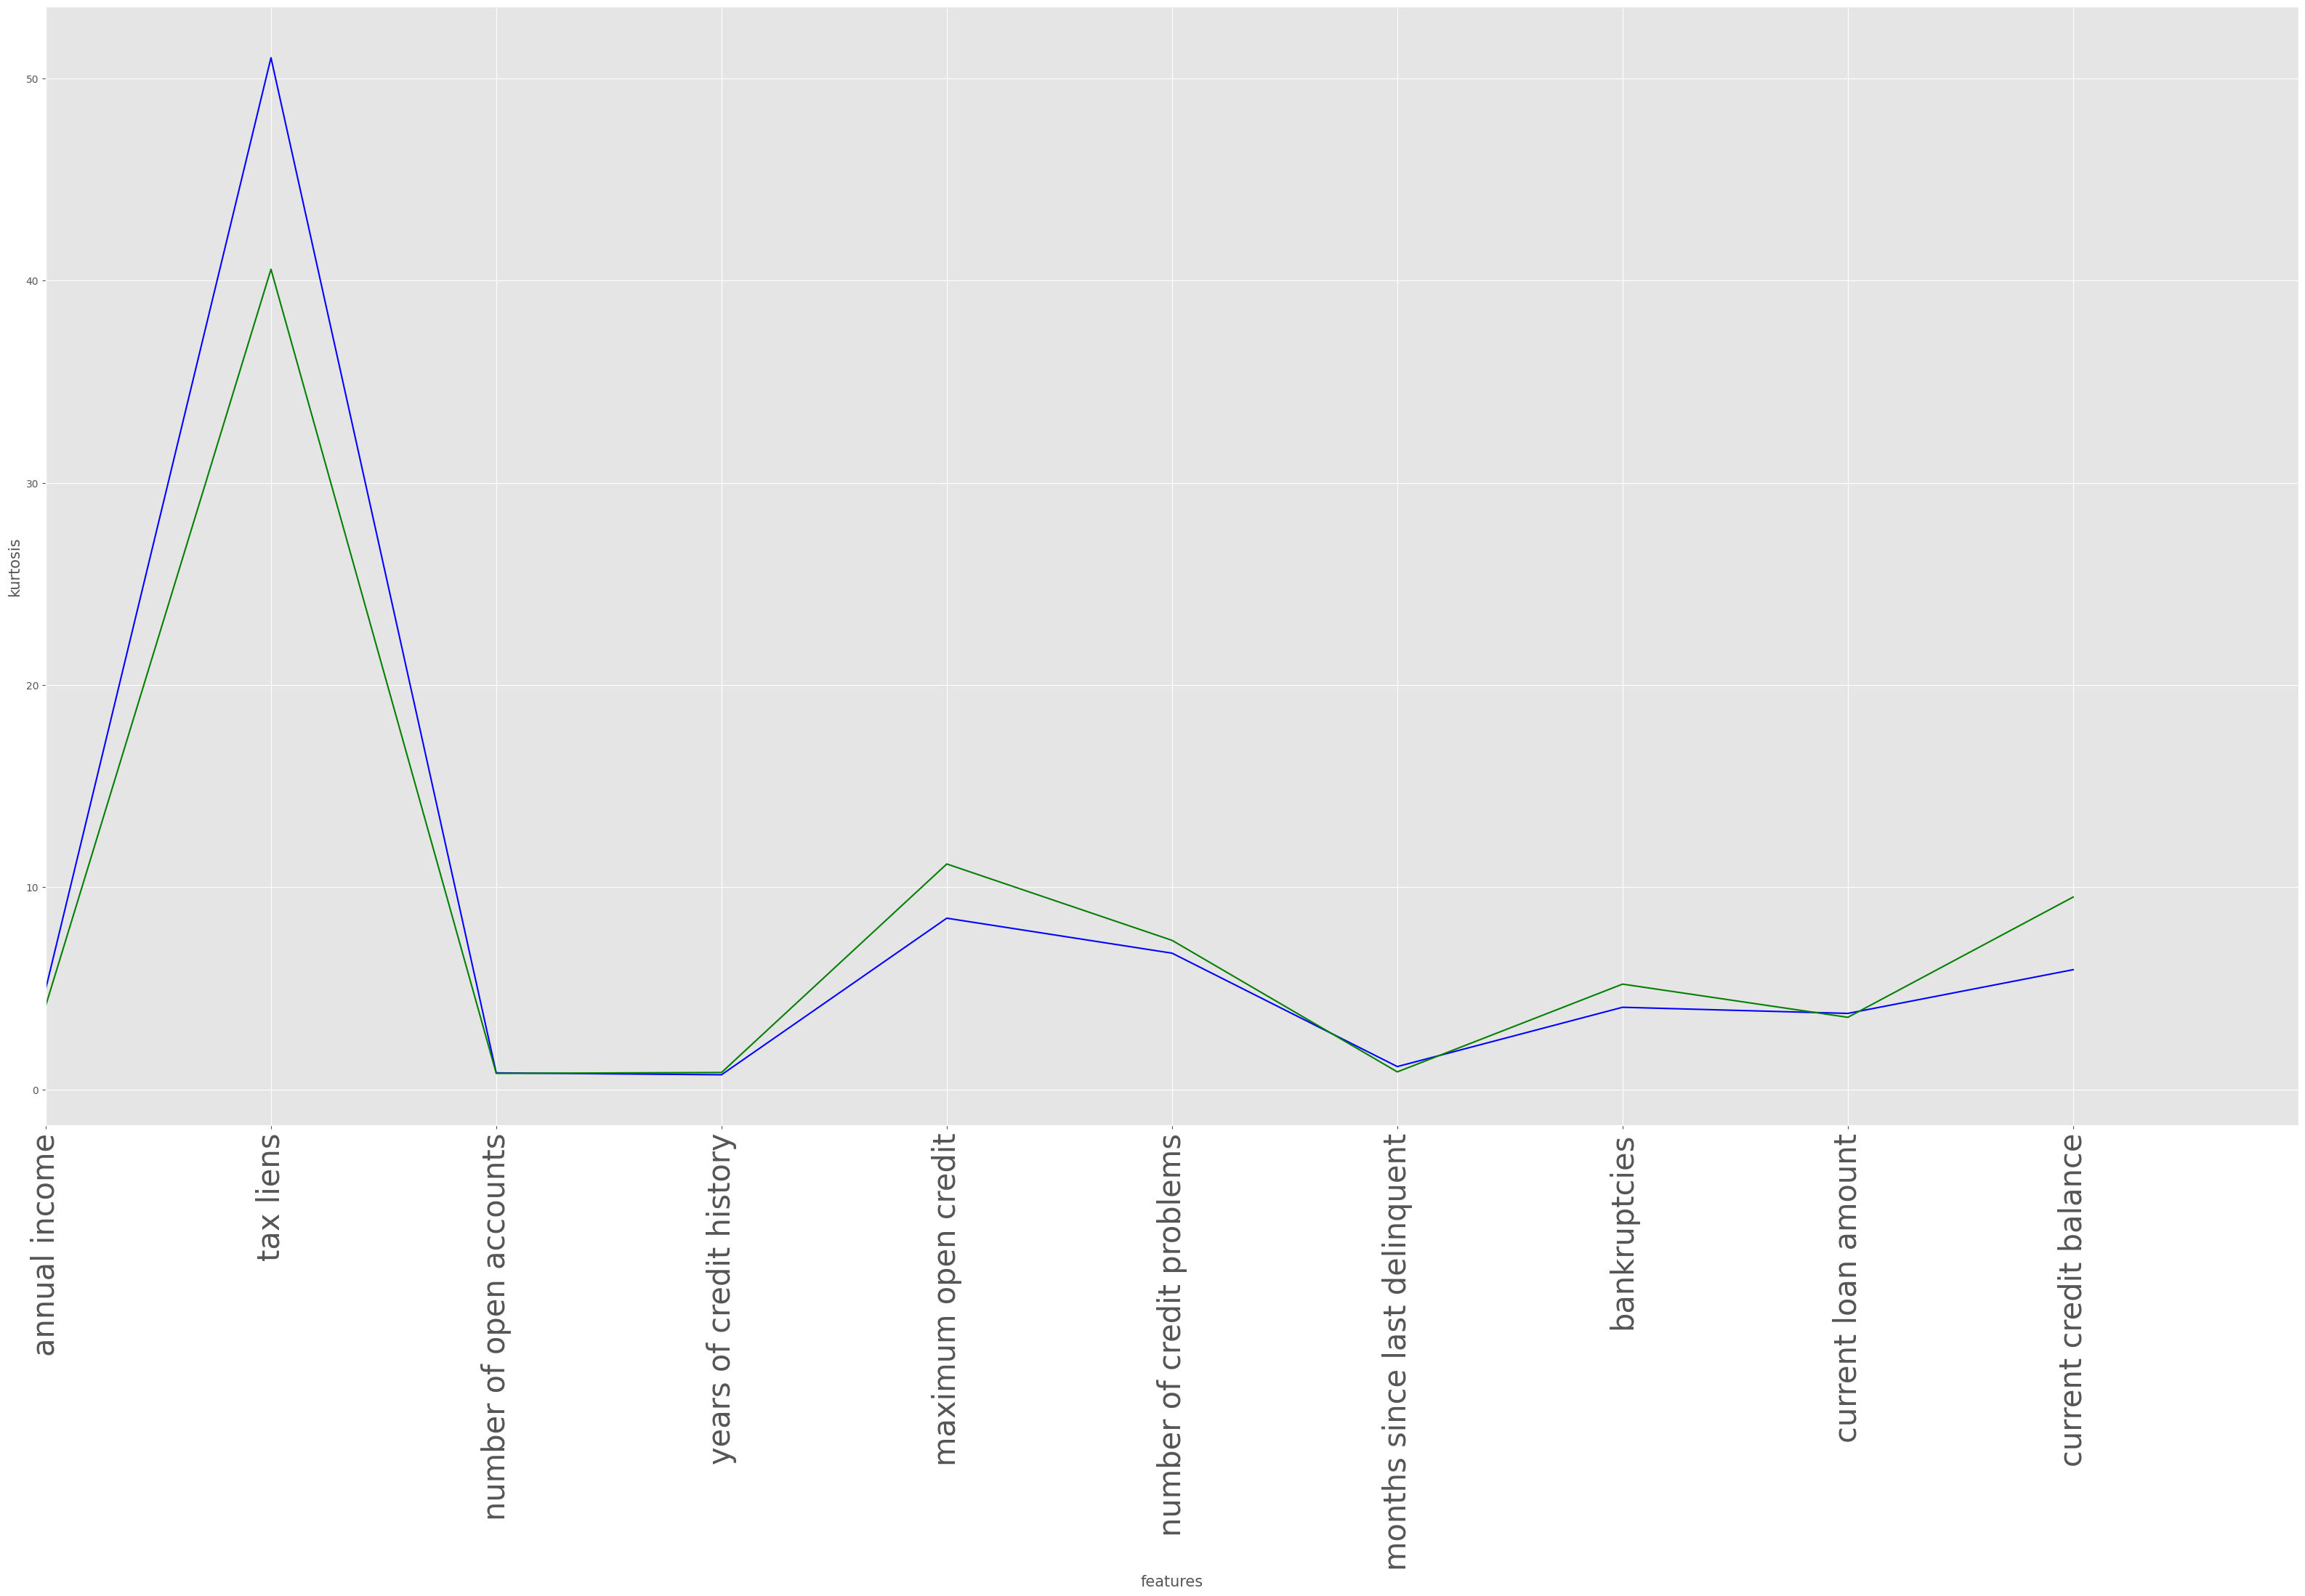

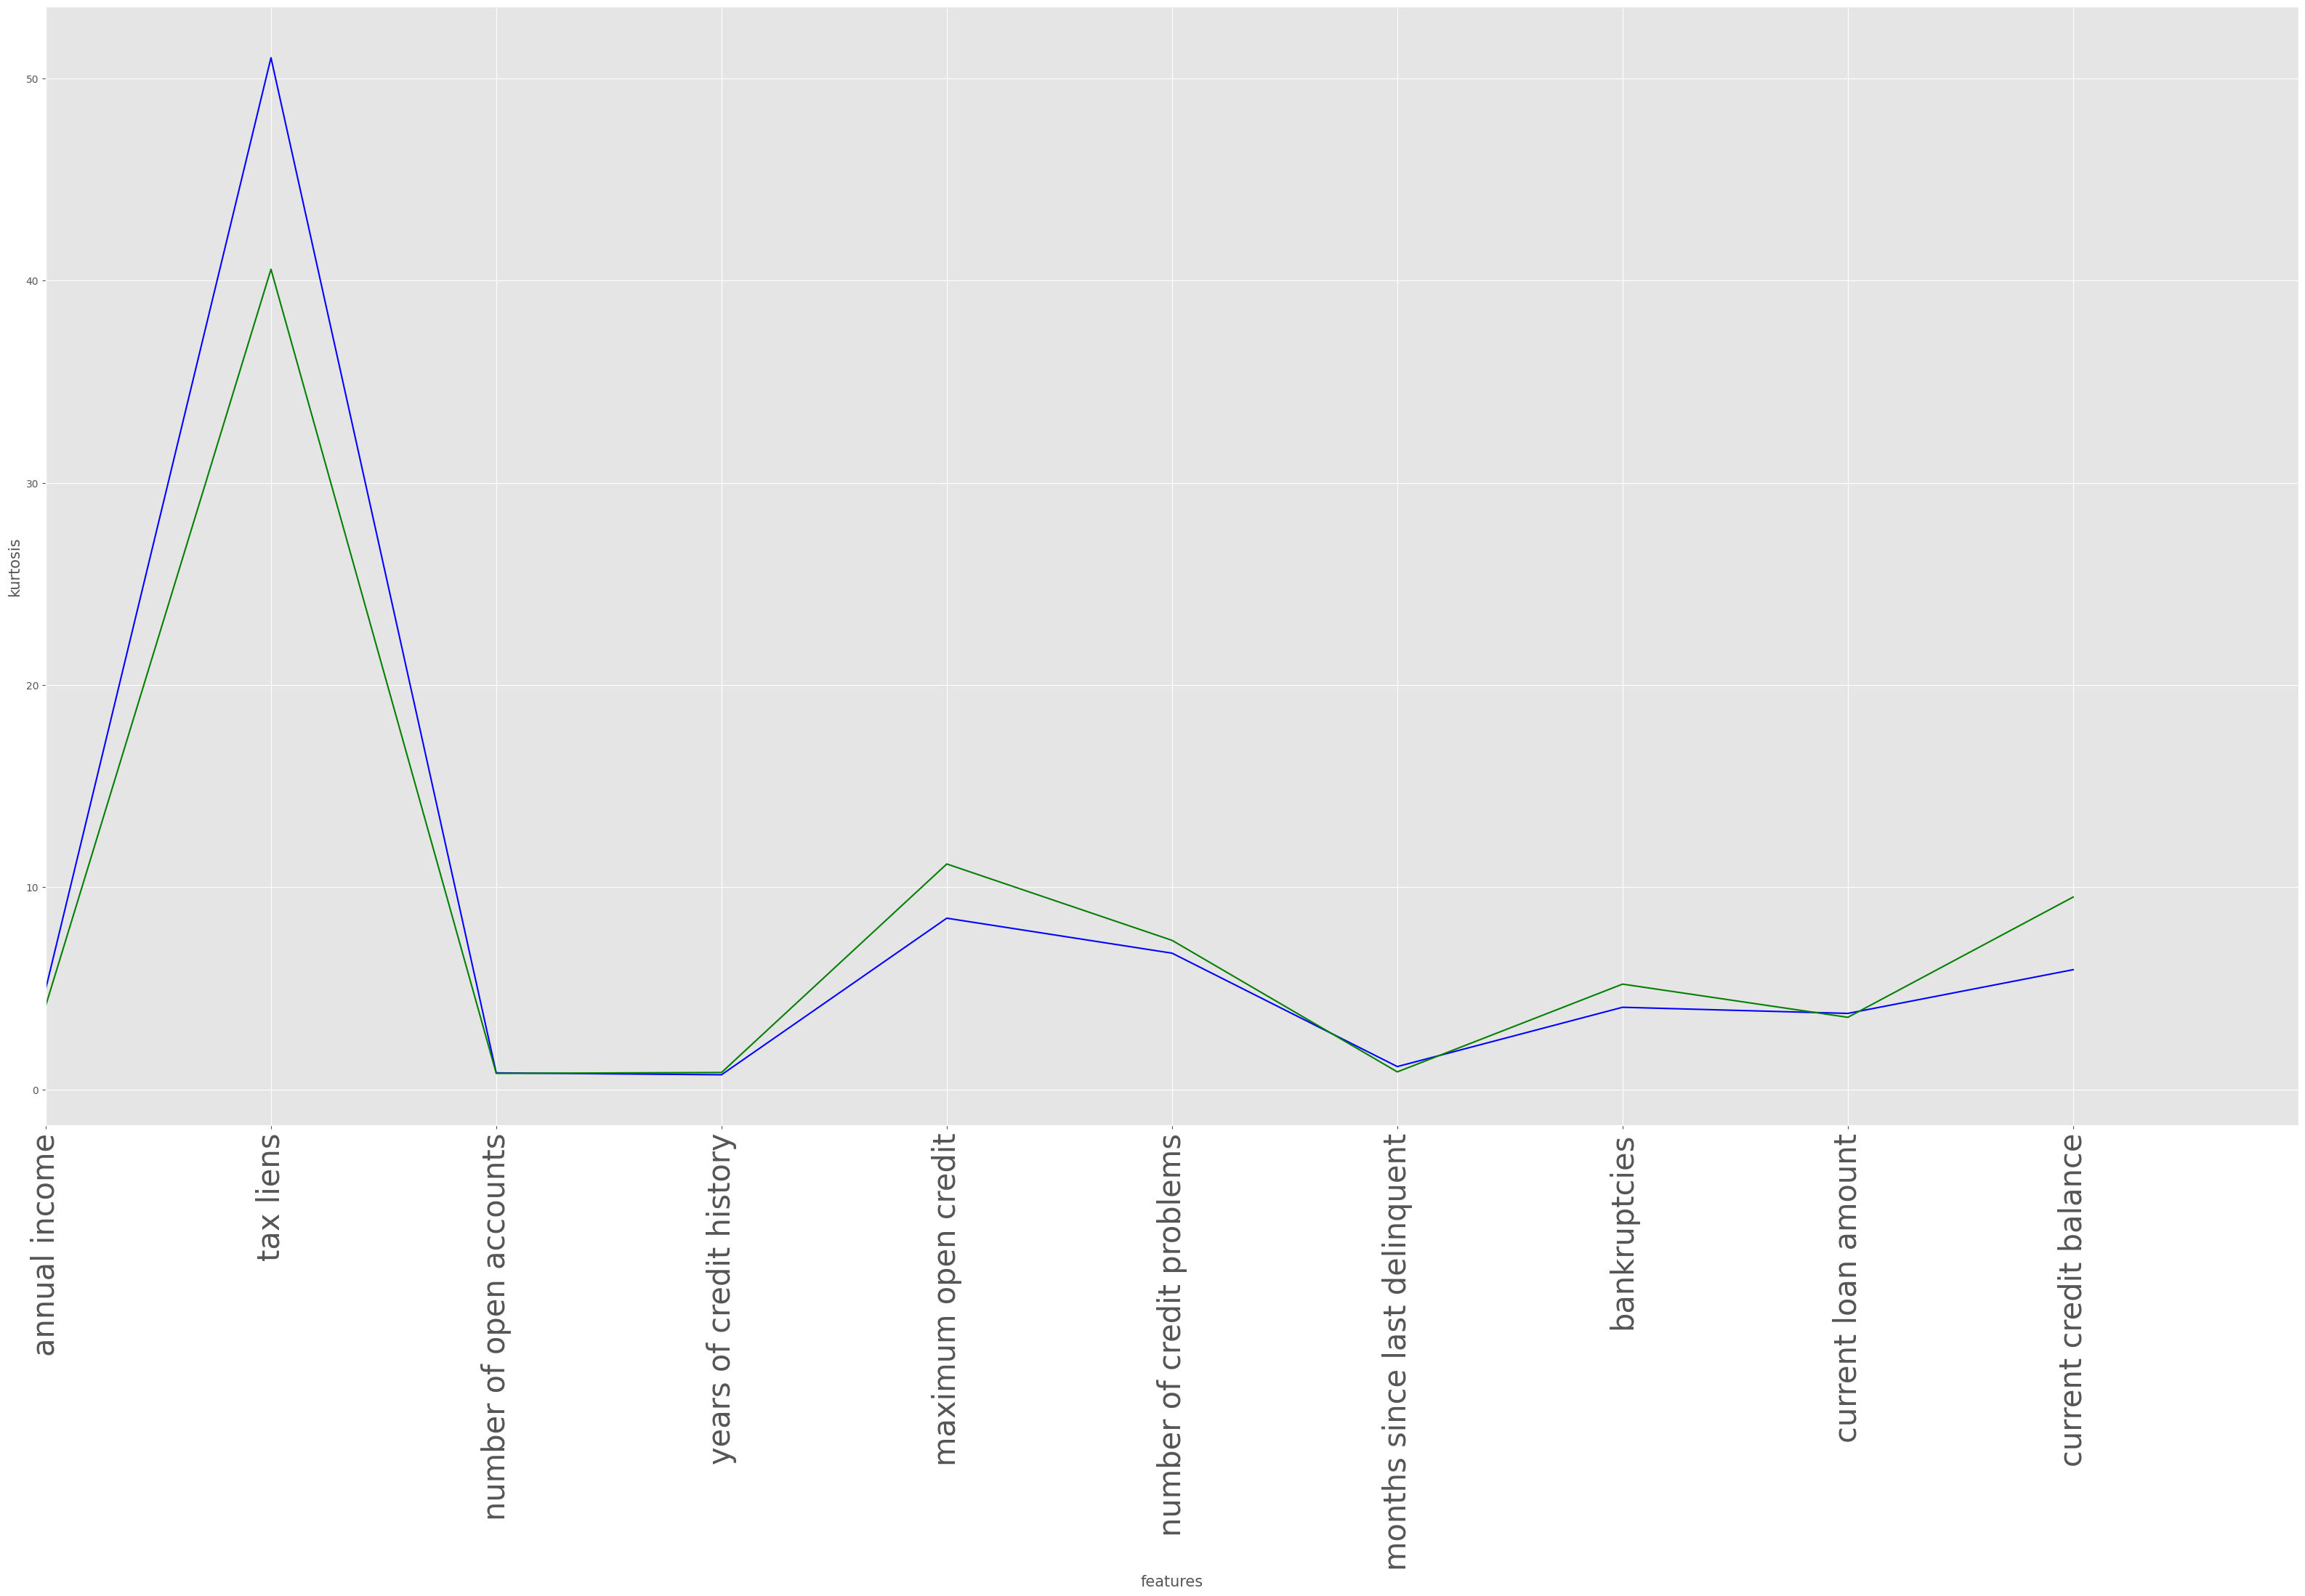

In [43]:
mc.connect_sign(train, test, base_columns)

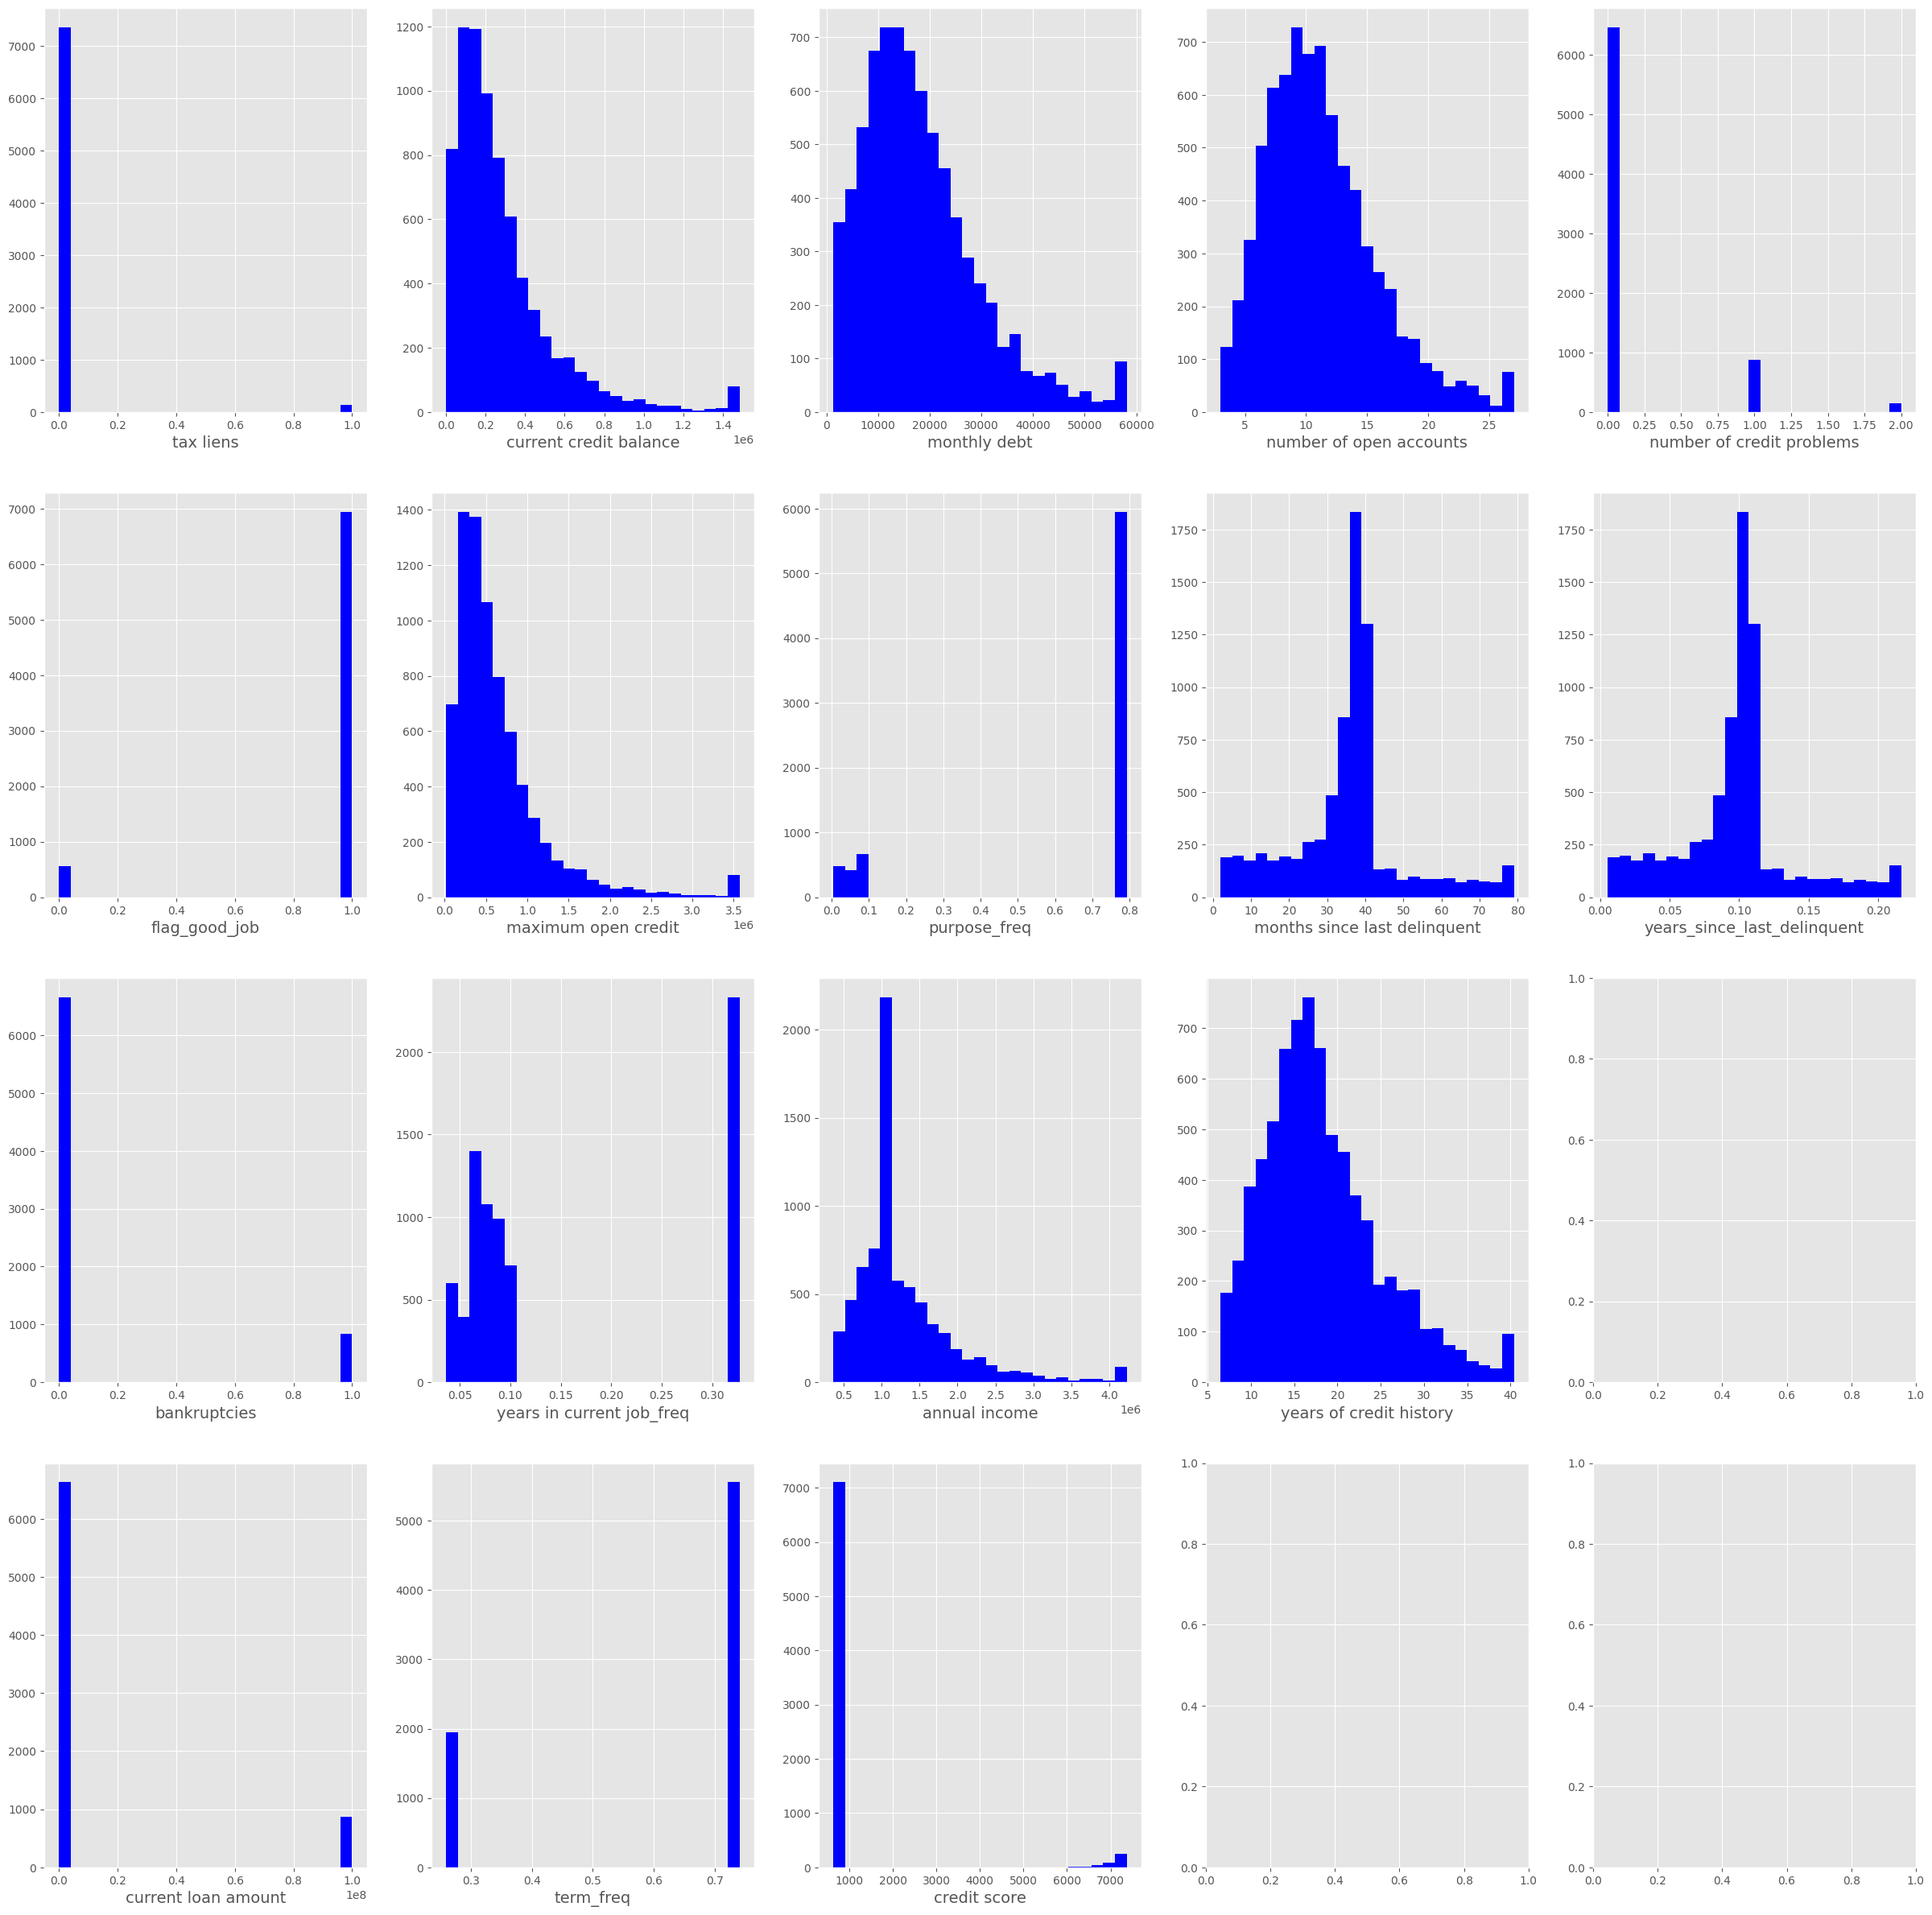

In [48]:
mc.distribution_sign(train, num, target_name='target', log=False)

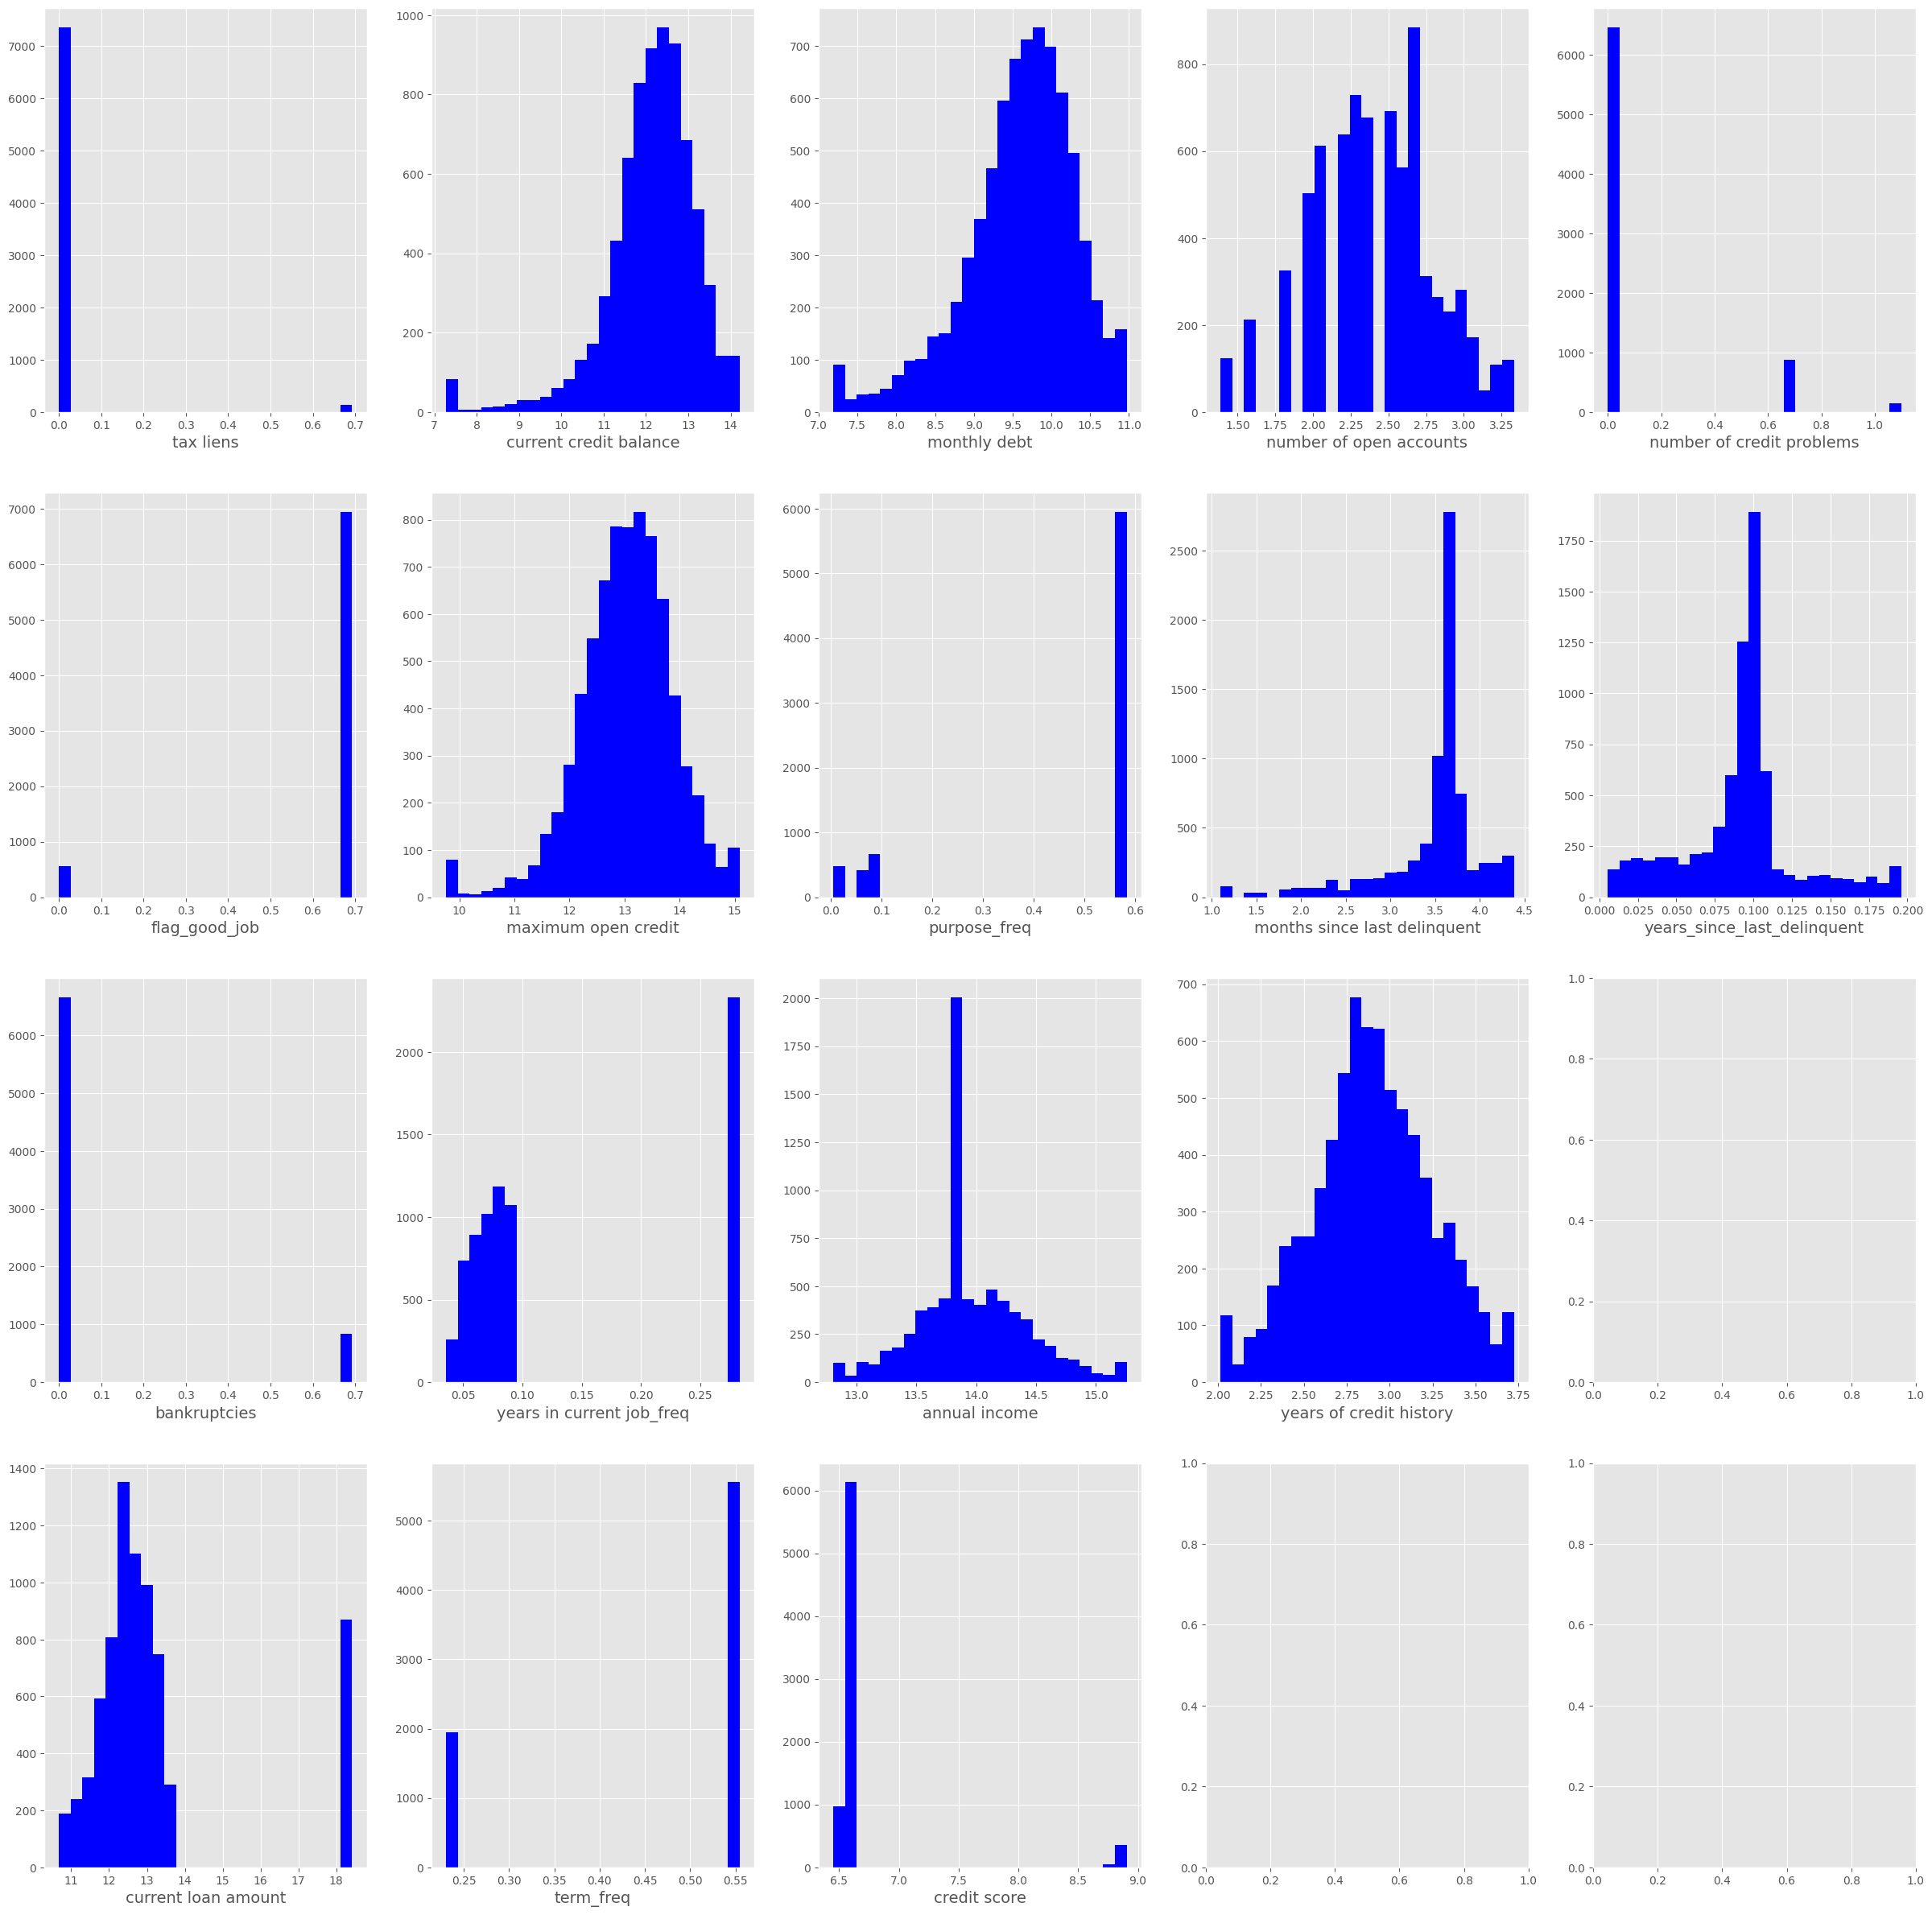

In [49]:
mc.distribution_sign(train, num, target_name='target', log=True)

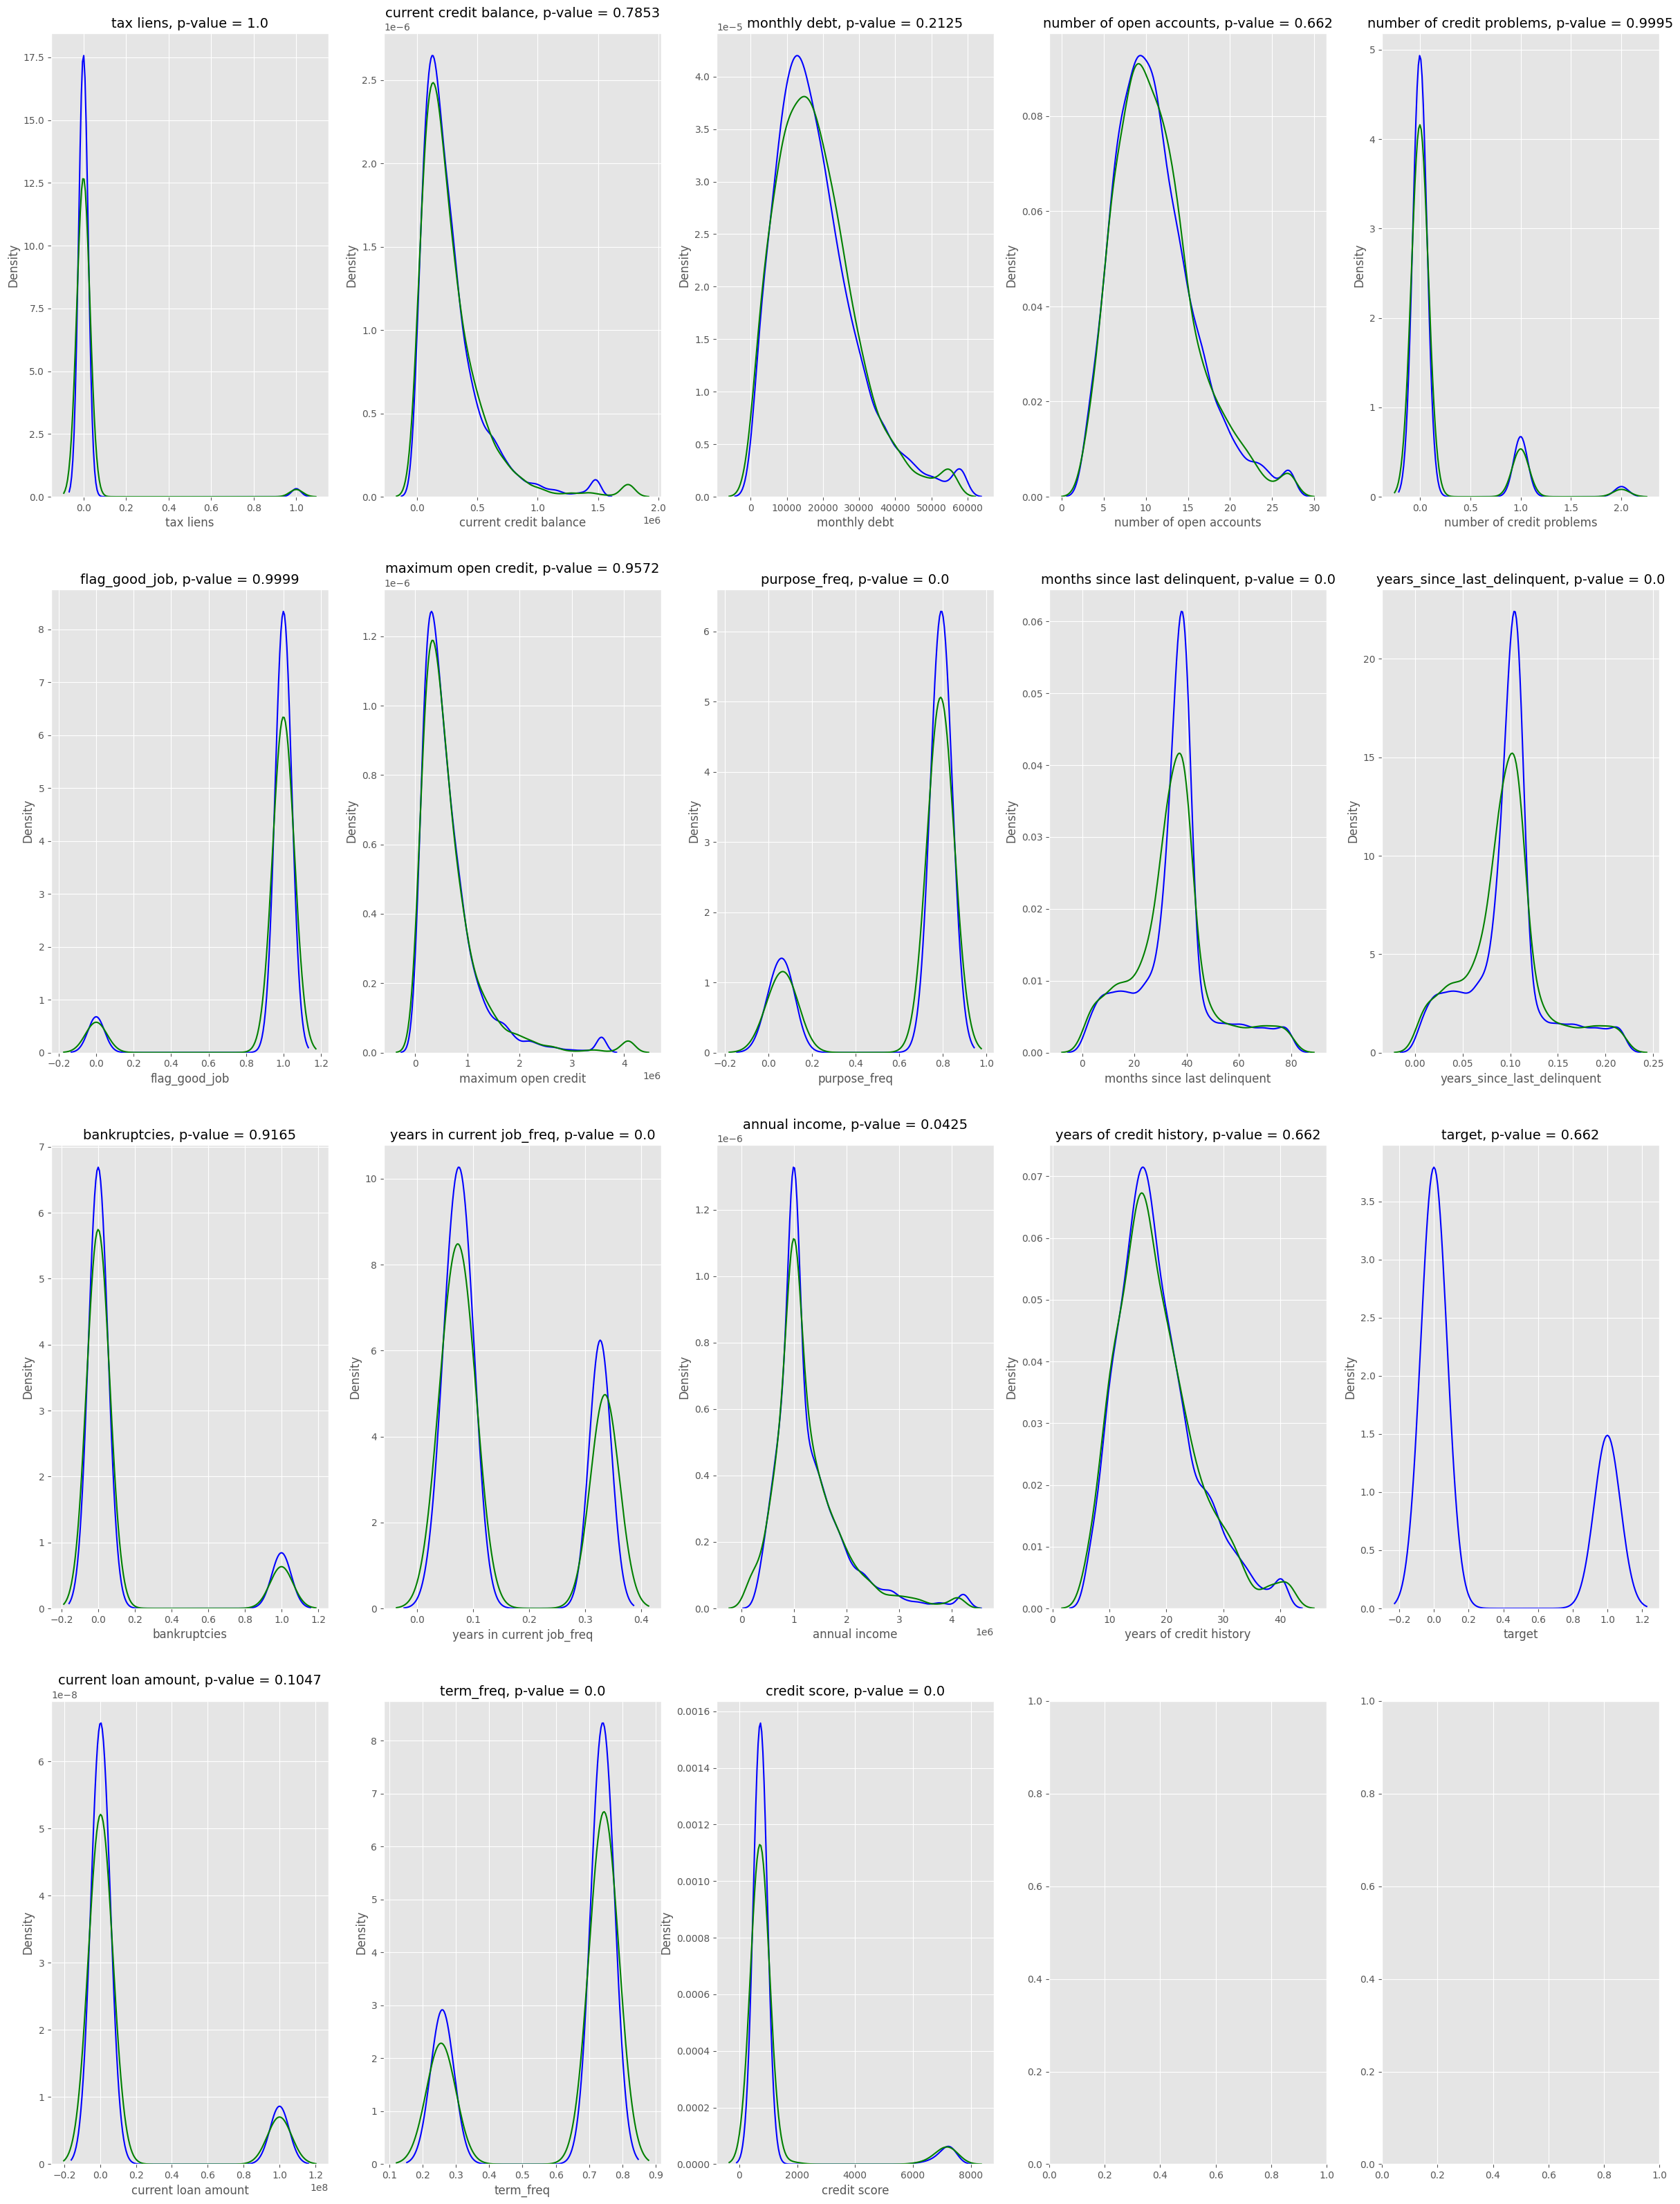

In [50]:
mc.similarity_sign(train, test, num)

# связь между признаками

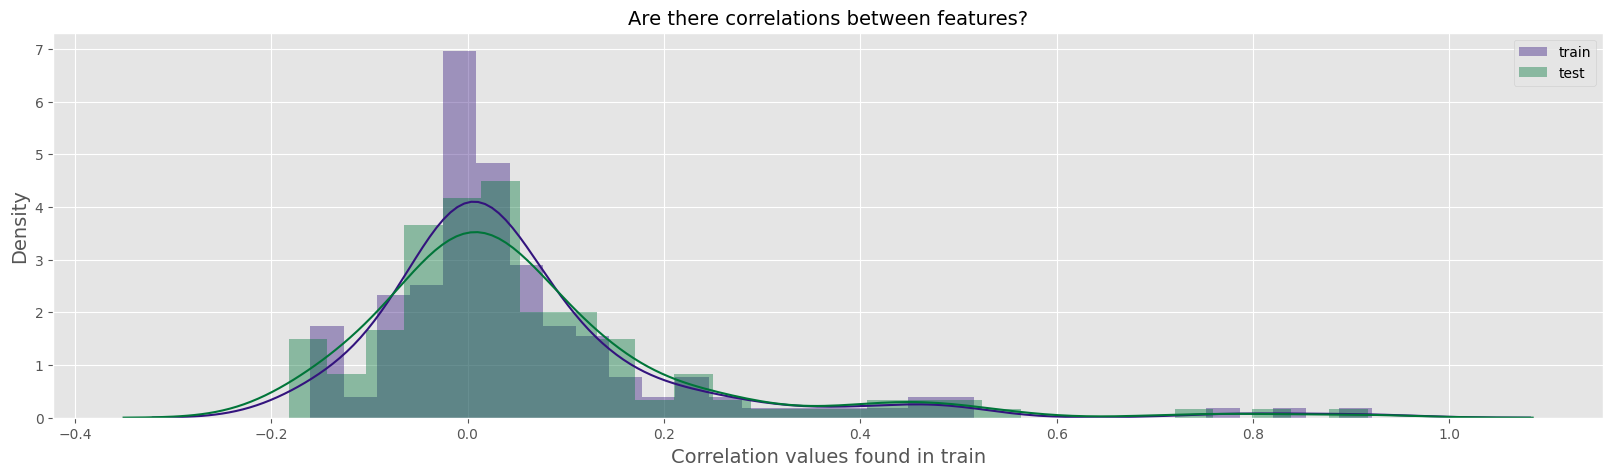

In [106]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="#33137d", label="train")
sns.distplot(test_correlations, color="#007539", label="test")
plt.title("Are there correlations between features?", size=14)
plt.xlabel("Correlation values found in train", size=14)
plt.ylabel("Density", size=14)
plt.legend()

# oof

In [101]:
num

['home ownership_freq',
 'years_since_last_delinquent',
 'credit score',
 'flag_good_job',
 'number of credit problems',
 'months since last delinquent',
 'current loan amount',
 'tax liens',
 'monthly debt',
 'number of open accounts',
 'years in current job_freq',
 'target',
 'bankruptcies',
 'purpose_freq',
 'term_freq',
 'maximum open credit',
 'current credit balance',
 'years of credit history',
 'annual income']

In [55]:
model_cb, dict_fold_cb=  mc.fit_kfold(train, target='target', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model oof ROC-AUC score is ==> 0.7905899111044676
Fold 1 ==> catboost model oof ROC-AUC score is ==> 0.7827994618786766
Fold 2 ==> catboost model oof ROC-AUC score is ==> 0.7656006823237698
Fold 3 ==> catboost model oof ROC-AUC score is ==> 0.7370327708851744
Fold 4 ==> catboost model oof ROC-AUC score is ==> 0.7616527007183744
Fold 5 ==> catboost model oof ROC-AUC score is ==> 0.778658037967449
Fold 6 ==> catboost model oof ROC-AUC score is ==> 0.7336475305331094
Fold 7 ==> catboost model oof ROC-AUC score is ==> 0.8002384793434804
Fold 8 ==> catboost model oof ROC-AUC score is ==> 0.7755137827032336
Fold 9 ==> catboost model oof ROC-AUC score is ==> 0.7566283229290875
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7682361680386822
Признаки для удаления set()
Лучших 5  признаков: {'annual income', 'current loan amount', 'maximum open credit', 'term_freq', 'credit score'}


In [56]:
# data, model, name_model, params=False, trh_flag=False,  threshold = 0.4, fold = 10, best_sign=5, oof= False):
model_lgbm, dict_fold_lgbm=  mc.fit_kfold(train,target='target', model=LGBMClassifier ,name_model="lgbm",params=params_lgbm, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> lgbm model oof ROC-AUC score is ==> 0.7838370160645042
Fold 1 ==> lgbm model oof ROC-AUC score is ==> 0.7677988903445911
Fold 2 ==> lgbm model oof ROC-AUC score is ==> 0.7664184157075152
Fold 3 ==> lgbm model oof ROC-AUC score is ==> 0.7381318748955852
Fold 4 ==> lgbm model oof ROC-AUC score is ==> 0.7484458669292792
Fold 5 ==> lgbm model oof ROC-AUC score is ==> 0.7668228859833464
Fold 6 ==> lgbm model oof ROC-AUC score is ==> 0.7210561949898444
Fold 7 ==> lgbm model oof ROC-AUC score is ==> 0.7912516658483552
Fold 8 ==> lgbm model oof ROC-AUC score is ==> 0.7659483060952514
Fold 9 ==> lgbm model oof ROC-AUC score is ==> 0.7441870660026654
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7593898182860939
Признаки для удаления {'bankruptcies', 'flag_good_job'}
Лучших 5  признаков: {'annual income', 'current loan amount', 'maximum open credit', 'term_freq', 'credit score'}


In [57]:

# data, target, model, name_model, params=False, trh_flag=False,  threshold = 0.4, fold = 10, best_sign=5, oof= False, eval_set=False)
model_xgb, dict_fold_xgb=  mc.fit_kfold(train, target='target', model=xgb.XGBClassifier ,name_model="xgb",params=params_xgb, trh_flag=True, threshold=0.4, fold=10, eval_set=False)

Fold 0 ==> xgb model oof ROC-AUC score is ==> 0.7870903639353198
Fold 1 ==> xgb model oof ROC-AUC score is ==> 0.77170290778957
Fold 2 ==> xgb model oof ROC-AUC score is ==> 0.7613361587633761
Fold 3 ==> xgb model oof ROC-AUC score is ==> 0.7434603311380562
Fold 4 ==> xgb model oof ROC-AUC score is ==> 0.7534489883846689
Fold 5 ==> xgb model oof ROC-AUC score is ==> 0.7680275039787565
Fold 6 ==> xgb model oof ROC-AUC score is ==> 0.7278882255185573
Fold 7 ==> xgb model oof ROC-AUC score is ==> 0.785614084309462
Fold 8 ==> xgb model oof ROC-AUC score is ==> 0.7644753454443431
Fold 9 ==> xgb model oof ROC-AUC score is ==> 0.7562776180122045
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7619321527274315
Признаки для удаления set()
Лучших 5  признаков: {'annual income', 'current loan amount', 'maximum open credit', 'term_freq', 'credit score'}


In [74]:
subb(test, model_lgbm, tr_h=True, tr = 0.29, name_model="lgbm")
subb(test, model_xgb, tr_h=True, tr = 0.29, name_model="xgb") # 61194
subb(test, model_cb, tr_h=True, tr = 0.4, name_model="cb")

In [65]:
pred_train_cb = model_cb.predict_proba(train.drop('target', axis=1))[:,1]
pred_train_lgbm = model_lgbm.predict_proba(train.drop('target', axis=1))[:,1]
pred_train_xgb = model_xgb.predict_proba(train.drop('target', axis=1))[:,1]

In [66]:
pred_test_cb = model_cb.predict_proba(test)[:,1]
pred_test_lgbm = model_lgbm.predict_proba(test)[:,1]
pred_test_xgb = model_xgb.predict_proba(test)[:,1]

In [67]:
print(roc_auc_score(train['target'].values, pred_train_cb))
print(roc_auc_score(train['target'].values, pred_train_lgbm))
print(roc_auc_score(train['target'].values, pred_train_xgb))

0.8760557549853369
0.9301731719742828
0.9105185302191539


* 0.8784518407752937
* 
0.931300054442119
* 
0.91177881652478  67

## Hill

In [68]:
x = pd.DataFrame({'LGBM': pred_train_lgbm,
                  'XGB': pred_train_xgb,
                  'Cat': pred_train_cb})
y = train['target']
        
x_test = pd.DataFrame({'LGBM': pred_test_lgbm,
                       'XGB': pred_test_xgb,
                       'Cat': pred_test_cb})
    
hill_results = mc.hill_climbing(x, y, x_test)
# hill_results = hill_climbing(x, y)
    
hill_ens_score_fold = roc_auc_score(y, hill_results[0])

print('==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.93667416018177


In [31]:
# hill_pred_test = np.where(hill_results[1] > 0.05, 1, 0)
# sub['Credit Default'] = hill_pred_test
# sub.to_csv(f'submission/sample_submission_hill.csv', index=False)

In [ ]:
# subb(test, model_cb, tr_h=True, tr = 0.5, name_model="cb")

In [69]:
best_sign = ['maximum open credit', 'current loan amount', 'annual income', 'term_freq', 'credit score']
train_oof = pd.DataFrame()
train_oof['oof_cb'] = pred_train_cb
train_oof['oof_lgbm'] = pred_train_lgbm
train_oof['oof_xgb'] = pred_train_xgb
train_oof['oof_hill'] = hill_results[0]
train_oof['target'] = train['target']
train_oof[best_sign] = train[best_sign]
train_oof.head()

,oof_cb,oof_lgbm,oof_xgb,oof_hill,target,maximum open credit,current loan amount,annual income,term_freq,credit score
0,0.012385,0.006119,0.015955,0.002857,0,685960.0,99999999.0,482087.0,0.7408,749.0
1,0.592823,0.503982,0.611641,0.458040,1,1181730.0,264968.0,1025487.0,0.2592,737.0
2,0.013025,0.004343,0.018855,-0.000186,0,1182434.0,99999999.0,751412.0,0.7408,742.0
3,0.394660,0.247728,0.253554,0.173470,0,147400.0,121396.0,805068.0,0.7408,694.0
4,0.357836,0.231908,0.208252,0.168550,0,385836.0,125840.0,776264.0,0.7408,719.0


In [70]:
test_oof = pd.DataFrame()
test_oof['oof_cb'] = pred_test_cb
test_oof['oof_lgbm'] = pred_test_lgbm
test_oof['oof_xgb'] = pred_test_xgb
test_oof['oof_hill'] = hill_results[1]
test_oof[best_sign] = test[best_sign]
test_oof.head()

,oof_cb,oof_lgbm,oof_xgb,oof_hill,maximum open credit,current loan amount,annual income,term_freq,credit score
0,0.361301,0.153202,0.224189,0.047402,220968.0,162470.0,999999.0,0.7444,694.5
1,0.585034,0.343162,0.399251,0.220456,55946.0,78298.0,231838.0,0.7444,699.0
2,0.990580,0.988479,0.957923,0.987723,204600.0,200178.0,1152540.0,0.7444,7260.0
3,0.409406,0.392855,0.308821,0.385338,456302.0,217382.0,1220313.0,0.7444,739.0
4,0.261922,0.068854,0.078991,-0.028747,1207272.0,777634.0,2340952.0,0.2556,706.0


In [82]:
test_oof.to_csv('data/test_oof.csv')
train_oof.to_csv('data/train_oof.csv')

target                 1.000000
oof_hill               0.729897
oof_lgbm               0.711747
oof_xgb                0.669185
oof_cb                 0.607483
credit score           0.376639
maximum open credit   -0.069751
annual income         -0.106126
term_freq             -0.181487
current loan amount   -0.226523
Name: target, dtype: float64


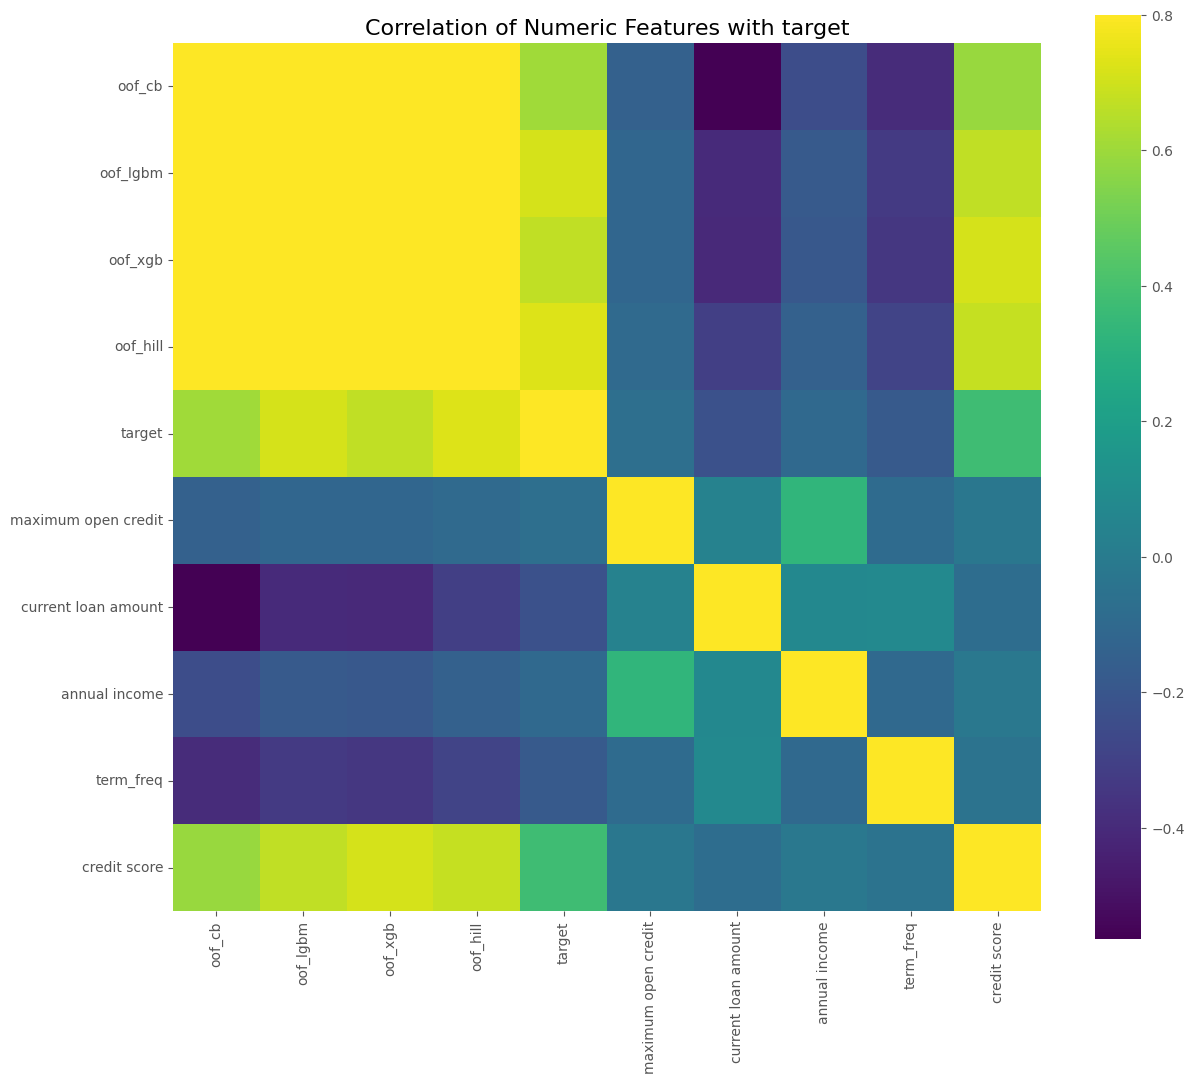

In [75]:
mc.corr(train_oof, 'target')

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [9]:
train_oof = pd.read_csv('data/train_oof.csv')
test_oof = pd.read_csv('data/test_oof.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [14]:
std_slc = StandardScaler()
linear = LogisticRegression()
pipe = Pipeline(steps=[('std_scl', std_slc),
                           ('linear', linear)])

In [15]:
model_oof, dict_fold_oof=  mc.fit_kfold(train_oof, target='target', model=pipe ,name_model="pipe_lr", trh_flag=False, threshold=0.4, fold=10, eval_set=False, pipeline=True)

Fold 0 ==> pipe_lr model ROC-AUC score is ==> 0.8701738342902865
Fold 1 ==> pipe_lr model ROC-AUC score is ==> 0.8666742871211388
Fold 2 ==> pipe_lr model ROC-AUC score is ==> 0.8510142531808069
Fold 3 ==> pipe_lr model ROC-AUC score is ==> 0.8610073068434613
Fold 4 ==> pipe_lr model ROC-AUC score is ==> 0.863891355766779
Fold 5 ==> pipe_lr model ROC-AUC score is ==> 0.8591520192738881
Fold 6 ==> pipe_lr model ROC-AUC score is ==> 0.8361719526242207
Fold 7 ==> pipe_lr model ROC-AUC score is ==> 0.8922897524023287
Fold 8 ==> pipe_lr model ROC-AUC score is ==> 0.8822858946482429
Fold 9 ==> pipe_lr model ROC-AUC score is ==> 0.6304797643262958
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.8413140420477448


In [19]:
pred = model_oof.predict_proba(test_oof)

In [20]:
pred

array([[9.79527842e-01, 2.04721584e-02],
       [8.26485950e-01, 1.73514050e-01],
       [4.56199290e-07, 9.99999544e-01],
       ...,
       [3.27969020e-01, 6.72030980e-01],
       [9.83396641e-01, 1.66033585e-02],
       [1.09966570e-06, 9.99998900e-01]])

In [18]:
pred = model_oof.predict(test_oof)
# pred = np.where(pred > 0.2, 1, 0)
sub['Credit Default'] = pred
sub.to_csv(f'submission/sample_submission_oof.csv', index=False)

# new features

number of credit problems

In [16]:
model_cb, dict_fold_cb=  mc.fit_kfold(train, target='target', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model ROC-AUC score is ==> 0.7905899111044676
Fold 1 ==> catboost model ROC-AUC score is ==> 0.7827994618786766
Fold 2 ==> catboost model ROC-AUC score is ==> 0.7656006823237698
Fold 3 ==> catboost model ROC-AUC score is ==> 0.7370327708851744
Fold 4 ==> catboost model ROC-AUC score is ==> 0.7616527007183744
Fold 5 ==> catboost model ROC-AUC score is ==> 0.778658037967449
Fold 6 ==> catboost model ROC-AUC score is ==> 0.7336475305331094
Fold 7 ==> catboost model ROC-AUC score is ==> 0.8002384793434804
Fold 8 ==> catboost model ROC-AUC score is ==> 0.7755137827032336
Fold 9 ==> catboost model ROC-AUC score is ==> 0.7566283229290875
Признаки для удаления set()
Лучших 5  признаков: {'annual income', 'maximum open credit', 'term_freq', 'credit score', 'current loan amount'}
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7682361680386822


In [24]:
aggs = ['number of credit problems']

In [25]:
t, tt = mc.encoder(train, test, aggs)

тип кодирования 1: OneHot, 2: LabelEncoder, 3: frequency 1


Готово, размер:  (7500, 21) (2500, 20)


In [26]:
model_cb, dict_fold_cb=  mc.fit_kfold(t, target='target', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model ROC-AUC score is ==> 0.7904756042873848
Fold 1 ==> catboost model ROC-AUC score is ==> 0.7806100466899384
Fold 2 ==> catboost model ROC-AUC score is ==> 0.7670427067854284
Fold 3 ==> catboost model ROC-AUC score is ==> 0.7345268137414379
Fold 4 ==> catboost model ROC-AUC score is ==> 0.7580476395642273
Fold 5 ==> catboost model ROC-AUC score is ==> 0.7789218229299476
Fold 6 ==> catboost model ROC-AUC score is ==> 0.7323286057206165
Fold 7 ==> catboost model ROC-AUC score is ==> 0.8038332047415304
Fold 8 ==> catboost model ROC-AUC score is ==> 0.7738830048397279
Fold 9 ==> catboost model ROC-AUC score is ==> 0.7569176544855158
Признаки для удаления set()
Лучших 5  признаков: {'term_freq', 'maximum open credit', 'credit score', 'current loan amount', 'annual income'}
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7676587103785757


In [27]:
pred = model_cb.predict_proba(tt)[:,1]
pred = np.where(pred > 0.4, 1, 0)
sub['Credit Default'] = pred
sub.to_csv(f'submission/sample_submission_cb.csv', index=False)

In [28]:
cont_cols = ['annual income', 'maximum open credit', 'term_freq', 'credit score', 'current loan amount']
t, tt = mc.transformer(train, test, cont_cols, "target")

In [29]:
t.shape, tt.shape

((7500, 58), (2500, 57))

In [30]:
model_cb, dict_fold_cb=  mc.fit_kfold(t, target='target', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model ROC-AUC score is ==> 0.7932277607294533
Fold 1 ==> catboost model ROC-AUC score is ==> 0.783494095613256
Fold 2 ==> catboost model ROC-AUC score is ==> 0.7708148317491581
Fold 3 ==> catboost model ROC-AUC score is ==> 0.7359688382030969
Fold 4 ==> catboost model ROC-AUC score is ==> 0.7601842977604657
Fold 5 ==> catboost model ROC-AUC score is ==> 0.7797219706495265
Fold 6 ==> catboost model ROC-AUC score is ==> 0.7328122114851972
Fold 7 ==> catboost model ROC-AUC score is ==> 0.8018780248299081
Fold 8 ==> catboost model ROC-AUC score is ==> 0.7762151925369993
Fold 9 ==> catboost model ROC-AUC score is ==> 0.7572069860419444
Признаки для удаления set()
Лучших 5  признаков: {'y_J_current loan amount', 'pow2_current loan amount', 'log_sqrtcredit score', 'credit score', 'monthly debt', 'current loan amount_pca_comb', 'pow_credit score', 'log_sqrtcurrent loan amount', 'number of open accounts', 'current credit balance'}
Средняя совокупность оценок ROC-AUC за 10-кр

In [31]:
pred = model_cb.predict_proba(tt)[:,1]
pred = np.where(pred > 0.4, 1, 0)
sub['Credit Default'] = pred
sub.to_csv(f'submission/sample_submission_cb.csv', index=False)

In [16]:
t = train.drop('credit score', axis=1)
tt = test.drop('credit score', axis=1)

In [17]:
model_cb, dict_fold_cb=  mc.fit_kfold(t, target='target', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model ROC-AUC score is ==> 0.7126414546861398
Fold 1 ==> catboost model ROC-AUC score is ==> 0.7118940639590606
Fold 2 ==> catboost model ROC-AUC score is ==> 0.6988894653078811
Fold 3 ==> catboost model ROC-AUC score is ==> 0.6990565291174633
Fold 4 ==> catboost model ROC-AUC score is ==> 0.6996984058595433
Fold 5 ==> catboost model ROC-AUC score is ==> 0.711665450324895
Fold 6 ==> catboost model ROC-AUC score is ==> 0.6672176841438859
Fold 7 ==> catboost model ROC-AUC score is ==> 0.7332187697271515
Fold 8 ==> catboost model ROC-AUC score is ==> 0.7187872623974189
Fold 9 ==> catboost model ROC-AUC score is ==> 0.7105281616048256
Признаки для удаления set()
Лучших 5  признаков: {'annual income', 'current loan amount', 'current credit balance', 'maximum open credit', 'term_freq'}
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.7063597247128265


In [20]:
pred = model_cb.predict_proba(tt)[:,1]
pred = np.where(pred > 0.4, 1, 0)
sub['Credit Default'] = pred
sub.to_csv(f'submission/sample_submission_cb.csv', index=False)

# test

In [35]:
t = pd.read_csv("data/train.csv")
tt = pd.read_csv("data/test.csv")

In [36]:
c, n = mc.view_csv(t)
ct, nt = mc.view_csv(tt)

rows: 7500, cols: 17

Категориальные признаки: 
Всего категориальных признаков: 4
home ownership уникальных значений: 4, ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
years in current job уникальных значений: 11
purpose уникальных значений: 15
term уникальных значений: 2, ['Short Term' 'Long Term']

Числовые признаки: 

Всего числовых признаков: 13
['credit score', 'tax liens', 'bankruptcies', 'maximum open credit', 'number of credit problems', 'annual income', 'current loan amount', 'years of credit history', 'credit default', 'current credit balance', 'monthly debt', 'number of open accounts', 'months since last delinquent']

В колонке annual income пропущенно 1557 значений

В колонке years in current job пропущенно 371 значений

В колонке months since last delinquent пропущенно 4081 значений

В колонке bankruptcies пропущенно 14 значений

В колонке credit score пропущенно 1557 значений
rows: 2500, cols: 16

Категориальные признаки: 
Всего категориальных признаков: 4
home owner

In [37]:
t = t.drop(['annual income', 'credit score', 'months since last delinquent'], axis=1)
tt = tt.drop(['annual income', 'credit score', 'months since last delinquent'], axis=1)

In [38]:
t = mc.median_mode(t)
tt = mc.median_mode(tt)

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1753.68it/s]


на моду заменены значения в колонках: ['years in current job']
на медиану заменены значения в колонках: ['bankruptcies']


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2606.03it/s]

на моду заменены значения в колонках: ['years in current job']
на медиану заменены значения в колонках: ['bankruptcies']


In [39]:
c, n = mc.view_csv(t)
ct, nt = mc.view_csv(tt)

rows: 7500, cols: 14

Категориальные признаки: 
Всего категориальных признаков: 4
home ownership уникальных значений: 4, ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
years in current job уникальных значений: 11
purpose уникальных значений: 15
term уникальных значений: 2, ['Short Term' 'Long Term']

Числовые признаки: 

Всего числовых признаков: 10
['tax liens', 'bankruptcies', 'maximum open credit', 'number of credit problems', 'current loan amount', 'years of credit history', 'credit default', 'current credit balance', 'monthly debt', 'number of open accounts']
В данных пропусков нету
rows: 2500, cols: 13

Категориальные признаки: 
Всего категориальных признаков: 4
home ownership уникальных значений: 4, ['Rent' 'Home Mortgage' 'Own Home' 'Have Mortgage']
years in current job уникальных значений: 11
purpose уникальных значений: 14
term уникальных значений: 2, ['Short Term' 'Long Term']

Числовые признаки: 

Всего числовых признаков: 9
['tax liens', 'bankruptcies', 'maximum open 

In [40]:
aggs = ['home ownership', 'term']
t, tt = mc.encoder(t, tt, aggs)

тип кодирования 1: OneHot, 2: LabelEncoder, 3: frequency 1


Готово, размер:  (7500, 20) (2500, 19)


In [48]:
t = t.drop(['home ownership', 'term'], axis=1)
tt = tt.drop(['home ownership', 'term'], axis=1)

In [41]:
aggs = ['years in current job', 'purpose']
t, tt = mc.encoder(t, tt, aggs)

тип кодирования 1: OneHot, 2: LabelEncoder, 3: frequency 3


Готово, размер:  (7500, 20) (2500, 19)


In [45]:
list(t.columns)

['home ownership',
 'years in current job',
 'tax liens',
 'number of open accounts',
 'years of credit history',
 'maximum open credit',
 'number of credit problems',
 'bankruptcies',
 'purpose',
 'term',
 'current loan amount',
 'current credit balance',
 'monthly debt',
 'credit default',
 0,
 1,
 2,
 3,
 4,
 5]

In [49]:
model_cb, dict_fold_cb=  mc.fit_kfold(t, target='credit default', model=cb.CatBoostClassifier ,name_model="catboost",params=params_cb, trh_flag=True, threshold=0.4, fold=10, eval_set=False )

Fold 0 ==> catboost model ROC-AUC score is ==> 0.6916793429995867
Fold 1 ==> catboost model ROC-AUC score is ==> 0.7057127030045107
Fold 2 ==> catboost model ROC-AUC score is ==> 0.6983179312224674
Fold 3 ==> catboost model ROC-AUC score is ==> 0.6845219776837922
Fold 4 ==> catboost model ROC-AUC score is ==> 0.6692136570267918
Fold 5 ==> catboost model ROC-AUC score is ==> 0.6993291069120453
Fold 6 ==> catboost model ROC-AUC score is ==> 0.6680793816880479
Fold 7 ==> catboost model ROC-AUC score is ==> 0.7015413481097006
Fold 8 ==> catboost model ROC-AUC score is ==> 0.7183488812513151
Fold 9 ==> catboost model ROC-AUC score is ==> 0.6889072034789928
Признаки для удаления set()
Лучших 5  признаков: {'maximum open credit', '4', 'current loan amount', '5', 'current credit balance', 'number of open accounts'}
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6925651533377252


In [50]:
pred = model_cb.predict_proba(tt)[:,1]
pred = np.where(pred > 0.4, 1, 0)
sub['Credit Default'] = pred
sub.to_csv(f'submission/sample_submission_cb.csv', index=False)

# group

In [8]:
# tr = train.copy()
# ts = test.copy()

In [9]:
# tr = mc.split_group(tr.drop('target', axis=1)[['credit score', 'annual income', 'term_freq']].columns, tr)
# ts = mc.split_group(ts[['credit score', 'annual income', 'term_freq']].columns, ts)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 73.16it/s]


In [10]:
# tr.shape, ts.shape

((7500, 22), (2500, 21))

In [14]:
# model, dict_fold = fit_kfold(tr,threshold=0.4, fold=10, best_sign=5)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.7039233616755621
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6840383719192115
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.660038336747883
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6544724740391632
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6818797316427649
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6781691565036183
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6498254622831467
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.703286105071193
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6893455846250963
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.675054359262117
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6780032943769756
Признаки для удаления set()
Лучших 5  признаков: {'annual income', 'credit score', 'maximum open credit', 'term_freq', 'group_credit score', 'current loan amount'}


In [16]:
# subb(ts, model)

# categorical

In [28]:
aggs = []
for i in train.columns:
    if i == "target":
        continue
    if type(i) == int:
        continue
    if train[i].nunique() < 15:
        aggs.append(i)
aggs
print(len(aggs))
for i in aggs:
    if train[i].nunique() != test[i].nunique():
        continue
    print("*"*20)
    print(i)
    print("train : ", train[i].nunique())
    print(train[i].unique())
    
    print("test : ", test[i].nunique())
    print(test[i].unique())
    print(np.sort(train[i].unique()) == np.sort(test[i].unique()))

8
********************
tax liens
train :  2
[0. 1.]
test :  2
[0. 1.]
[ True  True]
********************
number of credit problems
train :  3
[1. 0. 2.]
test :  3
[0. 1. 2.]
[ True  True  True]
********************
bankruptcies
train :  2
[1. 0.]
test :  2
[0. 1.]
[ True  True]
********************
term_freq
train :  2
[0.7408 0.2592]
test :  2
[0.7444 0.2556]
[False False]
********************
flag_good_job
train :  2
[1 0]
test :  2
[1 0]
[ True  True]
********************
home ownership_freq
train :  3
[0.08626667 0.48653333 0.4272    ]
test :  3
[0.408  0.4928 0.0992]
[False False False]


In [41]:
train_cat.columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [13]:
train_cat['years in current job'] = train_cat['years in current job'].fillna('10+ years')
test_cat['years in current job'] = test_cat['years in current job'].fillna('10+ years')

In [14]:
train[train_cat.columns] = train_cat
test[test_cat.columns] = test_cat

In [15]:
aggs = ['number of credit problems', 'term', 'years in current job', 'home ownership']

In [16]:
train[aggs] = train[aggs].astype("str")
test[aggs] = test[aggs].astype("str")

In [56]:
def encoder(data, data_t, aggs):
    try:
        # for i in aggs:
        #     if data[i].isna().sum() > 0 or data_t[i].isna().sum() > 0:
        #         print(f"В столбце {i} есть пропуски")
        #         check = int(input("Продолжить? 1: да, 2: нет"))
        #         if check == 2:
        #             return data, data_t
        #         elif check not in [1,2]:
        #             print("не правильный ввод")
        #             return data, data_t
    
        type_encoder = int(input("тип кодирования 1: OneHot, 2: LabelEncoder, 3: frequency"))
        data_copy, data_copy_t = data.copy(), data_t.copy()
        if type_encoder == 1:
            onehotencoder = OneHotEncoder()
            # train
            data_new = onehotencoder.fit_transform(data_copy[aggs])
            data_new = pd.DataFrame(data_new.toarray())
            data_copy[data_new.columns] = data_new
            # test
            data_new_t = onehotencoder.fit_transform(data_copy_t[aggs])
            data_new_t = pd.DataFrame(data_new_t.toarray())
            data_copy_t[data_new_t.columns] = data_new_t
            
            return data_copy, data_copy_t
        elif type_encoder == 2:
            le = dict()
            labelencoder = LabelEncoder()
            for col in data_copy[aggs].columns:
                data_new = labelencoder.fit_transform(data_copy[col].values)
                le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
                data_copy[f'le_{col}'] = data_copy[col].apply(lambda x: le[x])
            for col in data_copy_t[aggs].columns:
                data_new = labelencoder.fit_transform(data_copy_t[col].values)
                le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
                data_copy_t[f'le_{col}'] = data_copy_t[col].apply(lambda x: le[x])
            return data_copy, data_copy_t
        elif type_encoder == 3:
            for col in aggs:
                d = dict(data_copy[col].value_counts(normalize=True))
                d_t = dict(data_copy_t[col].value_counts(normalize=True))
                data_copy[col] = data_copy[col].apply(lambda x: d[x])
                data_copy_t[col] = data_copy_t[col].apply(lambda x: d[x])
            return data_copy, data_copy_t
    except ValueError:
        print("ввод только числа: 1,2,3")

In [44]:
t = pd.read_csv('data/train.csv')
tt = pd.read_csv('data/test.csv')

In [24]:
t.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [57]:
aggs = ['years in current job']
t, tt = encoder(t, tt, aggs)

В столбце years in current job есть пропуски


Продолжить? 1: да, 2: нет 1
тип кодирования 1: OneHot, 2: LabelEncoder, 3: frequency 1


In [61]:
t.columns

Index([              'home ownership',                'annual income',
               'years in current job',                    'tax liens',
            'number of open accounts',      'years of credit history',
                'maximum open credit',    'number of credit problems',
       'months since last delinquent',                 'bankruptcies',
                            'purpose',                         'term',
                'current loan amount',       'current credit balance',
                       'monthly debt',                 'credit score',
                     'credit default',                              0,
                                    1,                              2,
                                    3,                              4,
                                    5,                              6,
                                    7,                              8,
                                    9,                             10,
      

In [58]:
t.shape, tt.shape

((7500, 29), (2500, 28))

In [39]:
d = dict(t['term'].value_counts(normalize=True))
t['term'] = t['term'].apply(lambda x: d[x])

In [42]:
t['purpose'].isna().sum()

0

In [45]:
mc.view_csv(t)
mc.view_csv(tt)

rows: 7500, cols: 17
Всего категориальных признаков: 4
Index(['home ownership', 'years in current job', 'purpose', 'term'], dtype='object')
Всего числовых признаков: 13
['current credit balance', 'number of credit problems', 'credit default', 'months since last delinquent', 'current loan amount', 'tax liens', 'maximum open credit', 'bankruptcies', 'annual income', 'years of credit history', 'number of open accounts', 'monthly debt', 'credit score']
В колонке annual income пропущенно 1557 значений
В колонке years in current job пропущенно 371 значений
В колонке months since last delinquent пропущенно 4081 значений
В колонке bankruptcies пропущенно 14 значений
В колонке credit score пропущенно 1557 значений
rows: 2500, cols: 16
Всего категориальных признаков: 4
Index(['home ownership', 'years in current job', 'purpose', 'term'], dtype='object')
Всего числовых признаков: 12
['current credit balance', 'number of credit problems', 'months since last delinquent', 'current loan amount', 'tax 

(Index(['home ownership', 'years in current job', 'purpose', 'term'], dtype='object'),
 ['current credit balance',
  'number of credit problems',
  'months since last delinquent',
  'current loan amount',
  'tax liens',
  'maximum open credit',
  'bankruptcies',
  'annual income',
  'years of credit history',
  'number of open accounts',
  'monthly debt',
  'credit score'])

In [18]:
onehotencoder = OneHotEncoder()

In [19]:
data_new = onehotencoder.fit_transform(train[aggs])
data_new = pd.DataFrame(data_new.toarray())
train[data_new.columns] = data_new

In [20]:
data_new_t = onehotencoder.fit_transform(test[aggs])
data_new_t = pd.DataFrame(data_new_t.toarray())
test[data_new_t.columns] = data_new_t

In [21]:
train.shape, test.shape

((7500, 43), (2500, 42))

In [22]:
le = dict()
labelencoder = LabelEncoder()
for col in train[aggs].columns:
    data_new = labelencoder.fit_transform(train[col].values)
    le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
    train[f'le_{col}'] = train[col].apply(lambda x: le[x])

In [23]:
le = dict()
labelencoder = LabelEncoder()
for col in test[aggs].columns:
    data_new = labelencoder.fit_transform(test[col].values)
    le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
    test[f'le_{col}'] = test[col].apply(lambda x: le[x])

In [24]:
train.shape, test.shape

((7500, 47), (2500, 46))

In [25]:
train = train.drop(['term', 'years in current job', 'home ownership'], axis=1)
test = test.drop(['term', 'years in current job', 'home ownership'], axis=1)


train = train.drop("purpose", axis=1)
test = test.drop("purpose", axis=1)

In [26]:
train['number of credit problems'] = train['number of credit problems'].astype("float32")
test['number of credit problems'] = test['number of credit problems'].astype("float32")

In [27]:
train.shape, test.shape

((7500, 43), (2500, 42))

In [29]:
model, dict_fold = fit_kfold(train,threshold=0.4, fold=10, best_sign=5)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.7086626981684531
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6785824196115327
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6670462239182618
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6582841667472676
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6713722973032383
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6866190681356559
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6618848314853731
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7099319632461246
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6958511608332748
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6713368871431578
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.680957171659234
Признаки для удаления set()
Лучших 5  признаков: {'maximum open credit', 'current loan amount', 'annual income', 'number of open accounts', 'le_term', 'credit score', 'current credit balance'}


In [30]:
subb(test, model)

# stat transform

In [14]:
def transformer(train, test, cont_cols):
    '''
    Алгоритм применяет множественные преобразования к выбранным столбцам и 
    находит наилучшее преобразование, используя одну переменную производительности модели  
    '''
    train_copy = train.copy()
    test_copy = test.copy()
    for col in cont_cols:
                
        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])
        
        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])
        
        # Box-Cox transformation
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')

        train_copy["bx_cx_" + col] = transformer.fit_transform(train_copy[[col]] + epsilon)
        test_copy["bx_cx_" + col] = transformer.fit_transform(test_copy[[col]] + epsilon)
        
        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])
        
        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])
        
        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col,  "pow_"+col , "pow2_"+col,"log_sqrt"+col]
        
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')
        
    return train_copy, test_copy

In [15]:
tr = train.copy()
ts = test.copy()

In [18]:
aggs = ['maximum open credit', 'credit score', 'current loan amount', 'term_freq', 'annual income']
train, test = transformer(train, test, aggs)
# test = transformer(test, aggs)

In [19]:
train.shape, test.shape

((7500, 59), (2500, 58))

In [28]:
def fit_kfold(data, cat_features=[], threshold = 0.4, fold = 10, best_sign=5):
    X = data.drop(columns = ['target'], axis = 1)
    Y = data['target']
    cat_preds = list()
    bad_features, best_features =  list(), list()
    dict_fold = dict()

    params = {
        "n_estimators": 2500,
        "learning_rate": 0.009906548674016816,
        "subsample": 0.5000411100811685,
#         'colsample_bylevel': 0.5853177112754828,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": False,
        "max_depth": 6,
        "l2_leaf_reg": 15,
        # "early_stopping_rounds": 100,
#         "thread_count": 6,
        # "random_seed": 42,
        "class_weights" : (1, 2),
        "random_state": 42
        }
    
    sk = RepeatedStratifiedKFold(n_splits = fold, n_repeats = 1, random_state = 42)
    for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
#         X_train, X_valid, Y_train, Y_valid = X_train[:4500], X_train[4500:], Y_train[:4500], Y_train[4500:]
        dict_fold[f"{i}_train"] = [train_idx]
        dict_fold[f"{i}_test"] = [test_idx]
        
        if len(cat_features) != 0:
            print("тут")
            Cat_md = cb.CatBoostClassifier(**params, cat_features=cat_features)
        else:
            Cat_md = cb.CatBoostClassifier(**params)
        
#         Cat_md.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])
        Cat_md.fit(X_train, Y_train)
        
#         cat_pred = Cat_md.predict(X_test)
        cat_pred = Cat_md.predict_proba(X_test)[:, 1]
        cat_pred = np.where(cat_pred > threshold, 1, 0)
        cat_score = roc_auc_score(Y_test, cat_pred)
        cat_preds.append(cat_score)
        print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)
        bad, dict_ = shap_shap(X_train, Cat_md)
#         print(dict_)
        bad_features.append(bad)
        best_features.append(list(dict_.keys())[:best_sign])
    bad_features = set(list(np.array(bad_features).flat))
    best_features = set(list(np.array(best_features).flat))
    print(f'Средняя совокупность оценок ROC-AUC за {fold}-кратный период составляет', np.mean(cat_preds))
    print(f"Признаки для удаления {bad_features}")
    print(f"Лучших {best_sign}  признаков: {best_features}")
    return Cat_md, dict_fold

In [29]:
model, dict_fold = fit_kfold(train,threshold=0.4, fold=10, best_sign=5)

Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.7033166562618154
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 0.6759093986582138
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 0.6648875836418152
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 0.6658152274266018
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 0.6735397304117684
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 0.6764237793350861
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 0.6573565229624809
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.7084326997264502
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 0.6749140772953637
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 0.6711966051764046
Средняя совокупность оценок ROC-AUC за 10-кратный период составляет 0.6771792280896001
Признаки для удаления set()
Лучших 5  признаков: {'current credit balance', 'pow_current loan amount', 'current loan amount', 'bx_cx_current loan amount', 'monthly debt', 'pow2_current loan amount', 'sqrt_credit score', 'number of open accounts', 'home ownership_freq'}


In [27]:
subb(test, model)